In [128]:
import time
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import statistics

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## Описание задачи:
плашка

Для прогнозирования временных рядов цен на медь можно выбрать различные метрики оценки точности модели. RMSE (Root Mean Squared Error) и MAE (Mean Absolute Error) являются двумя из самых популярных метрик для этой задачи.

RMSE измеряет среднеквадратичное отклонение между прогнозируемыми значениями и фактическими значениями. Она более чувствительна к большим ошибкам, так как она берет квадрат каждой ошибки. RMSE также имеет ту же размерность, что и исходные данные, что может быть полезно для интерпретации результатов.

MAE, с другой стороны, измеряет среднюю абсолютную ошибку между прогнозируемыми значениями и фактическими значениями. Она не учитывает направление ошибки и может быть полезна, когда все ошибки равнозначны.

Выбор между RMSE и MAE зависит от конкретной задачи и предпочтений аналитика. Если вам важны большие ошибки и вы хотите избежать их, то RMSE может быть более подходящей метрикой. Если вам важна общая ошибка без учета направления, то MAE может быть предпочтительнее.

В конечном счете, рекомендуется провести сравнительный анализ результатов, используя обе метрики, чтобы определить, какая из них лучше соответствует вашим потребностям и целям прогнозирования.

плашка

плашка

плашка

---

## Технический блок.

## Содержание:
### - Парсер
### - Функция проверки стационарности ряда

### В данном блоке представлена функция парсера для сбора данных с сайта westmetall, который в свою очередь собирает данные с Лондонской Биржи Металлов (LME), решение собирать датасет со сторонней площадки обусловлено нижеследующими факторами:
    
    - LME с недавнего времени использует защиту CloudFlare обойти которую не получилось ни с помощью Selenium, ни с помощью sneak-парсеров, ни с помощью Scrapy, были перепробованы разные стратегии, не приведшие к результату.
    
    - Westmetall предоставляет верифицированные исторические данные, доступ к которым непосредственно на LME, закрыт пэйволом. Верификация подтверждается фактом работы с LME и Westmetall на протяжение 5-6 лет на нынешнем месте работы. 
    
    - В принципе я мог взять готовые датасеты из собственных наработок, но в таком случае не представилось бы возможности представить на суд парсер.
    

In [2]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    df_2014 = pd.read_html(response.text)[9]
    df_2013 = pd.read_html(response.text)[10]
    #
    df_2012 = pd.read_html(response.text)[11]
    df_2011 = pd.read_html(response.text)[12]
    df_2010 = pd.read_html(response.text)[13]
    df_2009 = pd.read_html(response.text)[14]
    df_2008 = pd.read_html(response.text)[15]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015,
        df_2014, df_2013, df_2012,
        df_2011, df_2010, df_2009,
        df_2008
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
al_df = parser(metalls[0])
time.sleep(1)
cu_df = parser(metalls[1])
time.sleep(1)
pb_df = parser(metalls[2])
time.sleep(1)
ni_df = parser(metalls[3])
time.sleep(1)
zn_df = parser(metalls[4])


# Выведем полученные данные и сохраним как бекап.
al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
pb_df.to_csv('./data/lead.csv', sep=',')
ni_df.to_csv('./data/nickel.csv', sep=',')
zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-22,8188.0,8255.0,162.9
2023-09-21,8101.0,8170.0,162.9
2023-09-20,8277.0,8336.0,155.7
2023-09-19,8233.5,8295.0,149.6
2023-09-18,8320.0,8388.0,147.575


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-22,8188.0,8255.0,162.9
2023-09-21,8101.0,8170.0,162.9
2023-09-20,8277.0,8336.0,155.7
2023-09-19,8233.5,8295.0,149.6
2023-09-18,8320.0,8388.0,147.575


#### Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [3]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [4]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())

    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для {name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    print('\n')
    result_row = f'\n{date_of_experiment},{name},{rmse},{mae},{mape}'
    
    return result_row

In [5]:
# Функция для логирования метрик
def log_metrics_stock(metric):
    with open('./data/errors/stock.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/stock.csv', 'a') as file:
                file.write(metric)

        
def log_metrics_spot(metric):
    with open('./data/errors/spot.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/spot.csv', 'a') as file:
                file.write(metric)


In [6]:
# Функция для построения графиков
def visualisation_prog(pred_df, forecast_df, train_df, test_df, name=''):
    plt.plot(pred_df, label='Prediction')
    plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
    plt.plot(train_df, label='Training Data')
    plt.plot(test_df, label='Test Data')
    plt.title(f'Прогноз для {name}')
    plt.legend()
    plt.show()

---

## Часть 0.

### Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [7]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col=['date'])

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,3977.000000,3977.000000,3977.000000
mean,6997.931355,6999.287780,267.471612
std,1564.919693,1554.930532,135.480552
min,0.000000,0.000000,0.000000
25%,5896.000000,5913.000000,156.475000
50%,6935.500000,6945.000000,251.450000
75%,8141.500000,8122.000000,345.925000
max,10730.000000,10720.000000,678.225000


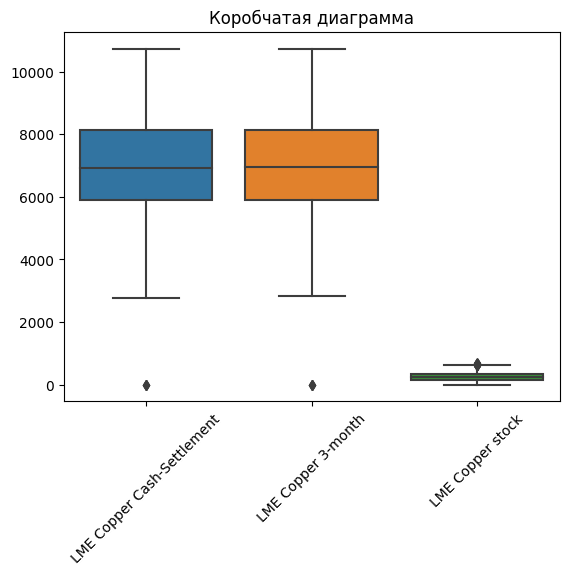

In [8]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,3973.000000,3973.000000,3973.000000
mean,7003.550969,7004.903096,267.565492
std,1553.696816,1543.624796,135.464198
min,2770.000000,2820.000000,51.175000
25%,5900.000000,5914.000000,156.475000
50%,6936.500000,6947.000000,251.475000
75%,8145.000000,8125.000000,346.050000
max,10730.000000,10720.000000,678.225000


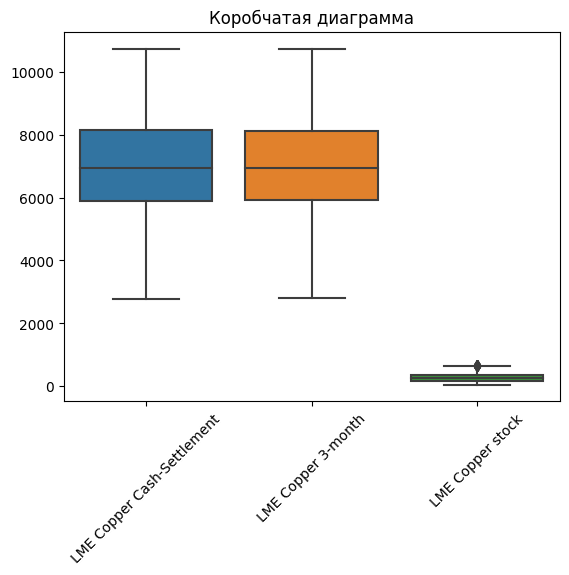

In [9]:
# Мы видим наличие нулевых значений
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

In [10]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [11]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data['LME Copper 3-month'] = data['LME Copper 3-month'].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2008]

display(data.head(), data.tail())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
365,2009-01-01,2986.500000,5885.000000,340.1625
366,2009-01-02,3071.000000,5793.666667,340.5500
367,2009-01-03,3081.166667,5702.333333,341.0500
368,2009-01-04,3091.333333,5611.000000,341.5500
369,2009-01-05,3101.500000,5630.000000,342.0500


,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
85,2023-12-16,NaN,8388.0,NaN
86,2023-12-17,NaN,8295.0,NaN
87,2023-12-18,NaN,8336.0,NaN
88,2023-12-19,NaN,8170.0,NaN
89,2023-12-20,NaN,8255.0,NaN


Диапазон планирования равен 90 дней


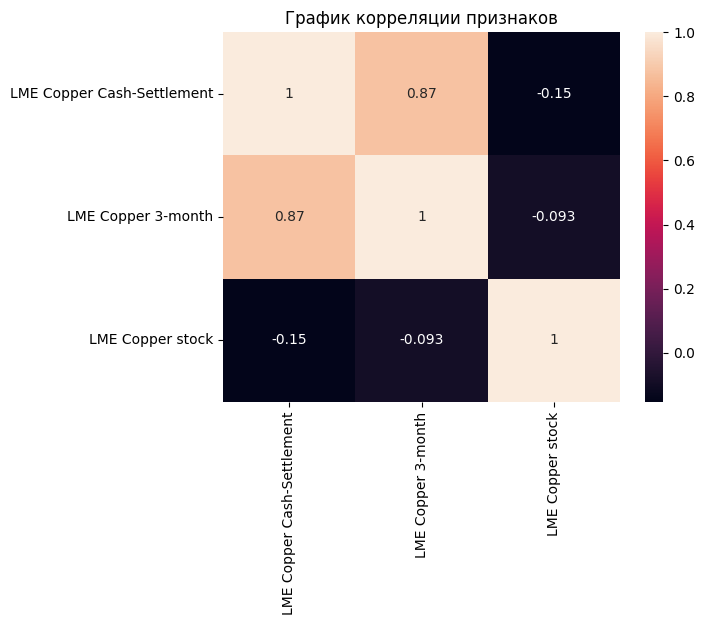

In [12]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data['LME Copper stock'].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data['LME Copper stock'].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

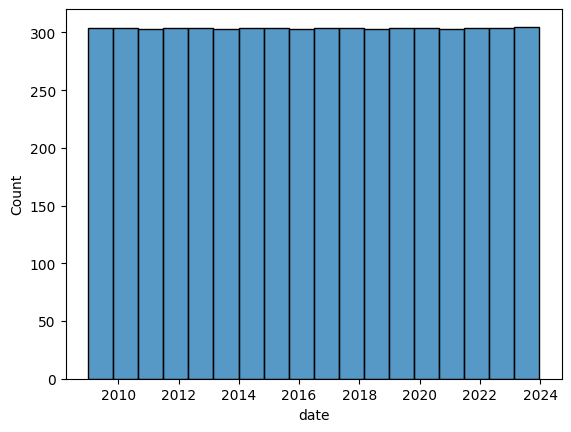

In [13]:
# Посмотрим на распределения цены и запасов
sns.histplot(data.iloc[:, 0]);

По цене нормальное распределение

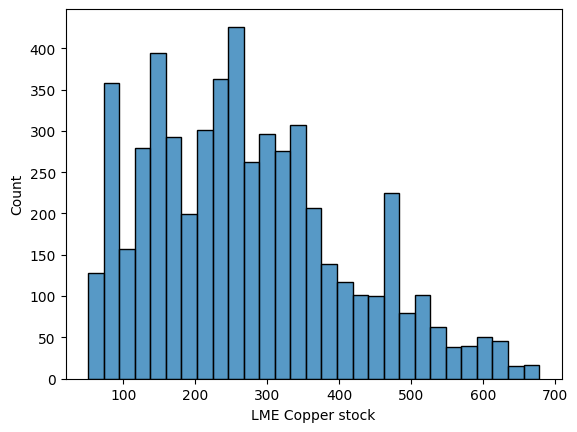

In [14]:
sns.histplot(data.iloc[:, -1]);

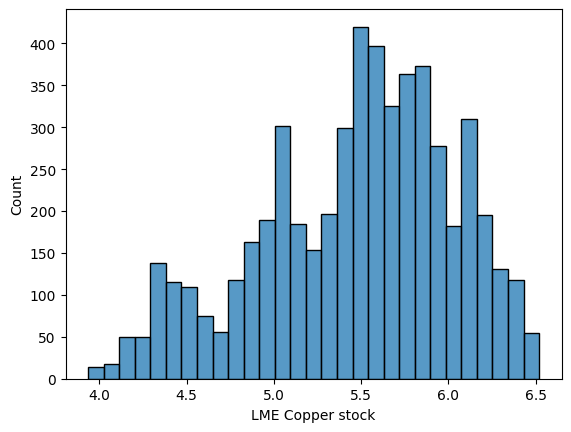

In [15]:
sns.histplot(np.log(data.iloc[:, -1]));

По запасам логнормальное, это может понадобиться в будущем

#### Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.
#### Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.
#### Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

## Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [16]:
# Будем прогнозировать временной ряд LME Copper stock и 
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data['LME Copper stock']
spot = working_data['LME Copper Cash-Settlement']

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)

# Выделим тренд, сезонность и остатки, интерполируем и заполним нулями первые элементы
trend_stock = decompose_stock.trend
seasonal_stock = decompose_stock.seasonal
seasonal_stock = seasonal_stock.resample('d').interpolate(method='linear')
seasonal_stock.fillna(0, inplace=True)
residuals_stock = decompose_stock.resid
residuals_stock = residuals_stock.resample('d').interpolate(method='linear')
residuals_stock.fillna(0, inplace=True)

trend_spot = decompose_spot.trend
seasonal_spot = decompose_spot.seasonal
seasonal_spot = seasonal_spot.resample('d').interpolate(method='linear')
seasonal_spot.fillna(0, inplace=True)
resid_spot = decompose_spot.resid
resid_spot = resid_spot.resample('d').interpolate(method='linear')
resid_spot.fillna(0, inplace=True)

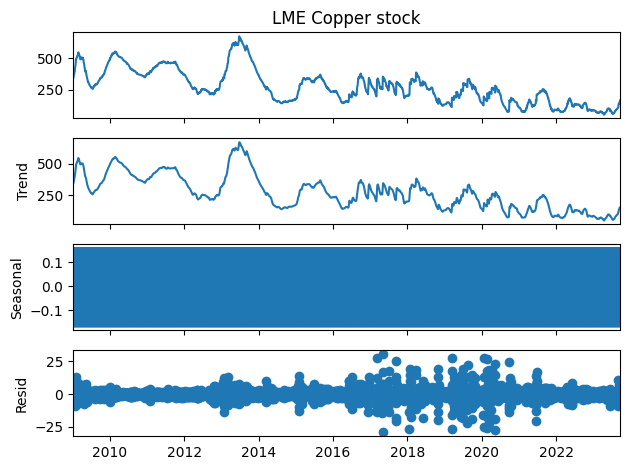

In [17]:
decompose_stock.plot()
plt.show()

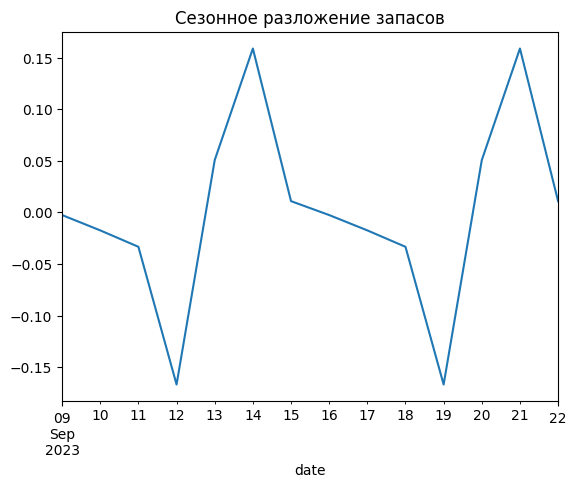

In [18]:
graph = decompose_stock.seasonal[-14:].plot()
graph.set_title('Сезонное разложение запасов')
plt.show()

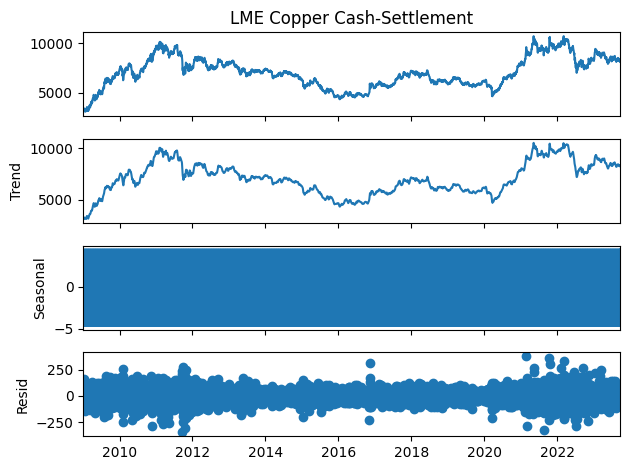

In [19]:
decompose_spot.plot()
plt.show()

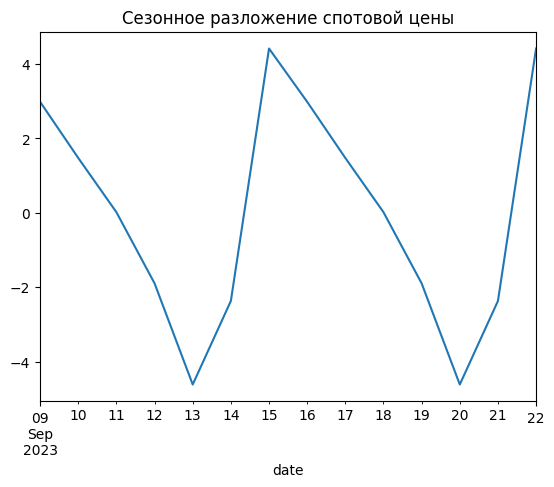

In [20]:
graph = decompose_spot.seasonal[-14:].plot()
graph.set_title('Сезонное разложение спотовой цены')
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.

> Так же нужно отметить сезонность равную периоду 7 дней (5 дней ьез интерполяции), что характерно для биржевых показателей.


---

Единичных корней нет, ряд стационарен
{'p_value': -12.627288556309123, 'crit_value (5%)': -2.862079684854021}
Единичных корней нет, ряд стационарен
{'p_value': -49.079006413325175, 'crit_value (5%)': -2.8620778770431343}


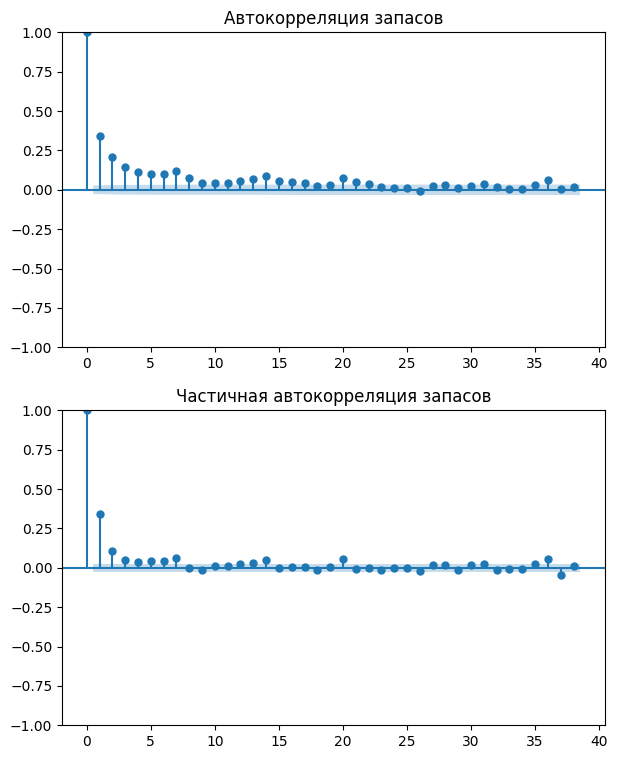

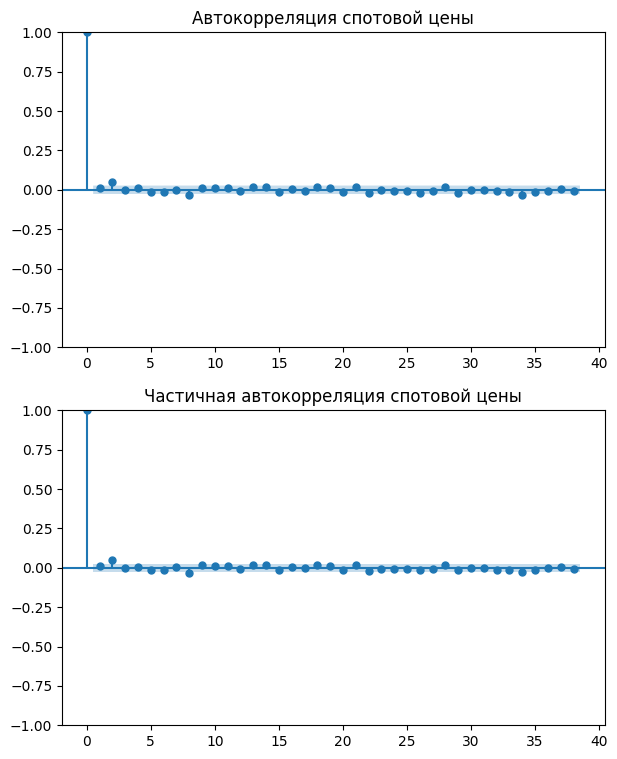

In [21]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock.diff().dropna(), name='запасов')
stationary_test(spot.diff().dropna(), name='спотовой цены')

> Вывод: оба ряда стационарны при дифференцировании 1 порядка, стоит отметить что ряд запасов условно стационарен (не все статистика близка к порогу 5%)

> p для запасов равен 1 (исходя из pacf графика это значение равно 2, но лучшие результаты были достигнуты именно при значении 1)

> p для спота равен 2 (так же исходя из pacf)

In [22]:
p_stock = 1
d_stock = 1
q_stock = 0

p_spot = 2
d_spot = 1
q_spot = 0

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [23]:
# Выделим тренировочную и тестовую выборки
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

# Сделаем то же самое для сезонных компонент
seasonal_stock_train = seasonal_stock[:-len(data_target)]
seasonal_stock_test = seasonal_stock[-len(data_target):]

residuals_stock_train = residuals_stock[:-len(data_target)]
residuals_stock_test = residuals_stock[-len(data_target):]

seasonal_spot_train = seasonal_spot[:-len(data_target)]
seasonal_spot_test = seasonal_spot[-len(data_target):]

resid_spot_train = resid_spot[:-len(data_target)]
resid_spot_test = resid_spot[-len(data_target):]

# И попробуем создать корректировку для послежующих прогнозов через базовую модель
ar_model_stock_sesonal = AutoReg(seasonal_stock_train, lags=1).fit()
ar_model_stock_resid = AutoReg(residuals_stock_train, lags=1).fit()

ar_model_spot_seasonal = AutoReg(seasonal_spot_train, lags=1).fit()
ar_model_spot_resid = AutoReg(resid_spot_train, lags=1).fit()

In [24]:
# Наши корректировки
stock_seasonal_mod = ar_model_stock_sesonal.predict(start=len(
    seasonal_stock_train), end=len(seasonal_stock_train)+len(seasonal_stock_test)-1)
stock_resid_mod = ar_model_stock_resid.predict(start=len(
    residuals_stock_train), end=len(residuals_stock_train)+len(residuals_stock_test)-1)

spot_seasonal_mod = ar_model_spot_seasonal.predict(start=len(
    seasonal_spot_train), end=len(seasonal_spot_train)+len(seasonal_spot_test)-1)
spot_resid_mod = ar_model_spot_resid.predict(start=len(
    resid_spot_train), end=len(resid_spot_train)+len(resid_spot_test)-1)

In [25]:
# Произведем прогнозирование
ar_model_stock = AutoReg(train_stock, lags=p_stock, seasonal=True).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot, seasonal=True).fit()

# Сделаем предсказание
pred_ar_stock = ar_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Подгоним полученные предсказания компонентами сезонного разложения
pred_ar_stock = pred_ar_stock + stock_seasonal_mod + stock_resid_mod

pred_ar_spot = pred_ar_spot + spot_seasonal_mod + spot_resid_mod

# Построим доверительный интервал
forecast_stock = ar_model_stock.get_prediction(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = ar_model_spot.get_prediction(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [26]:
# Оценим метрики и залогируем результаты
metric_stock = metrics_calculation(
    test_stock, pred_ar_stock, name='AR-baseline-stock')
log_metrics_stock(metric_stock)

metric_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='AR-baseline-spot')
log_metrics_spot(metric_spot)

RMSE для AR-baseline-stock: 30.965
MAE для AR-baseline-stock: 22.886
MAPE для AR-baseline-stock: 23.5%


RMSE для AR-baseline-spot: 130.04
MAE для AR-baseline-spot: 103.82
MAPE для AR-baseline-spot: 1.2%




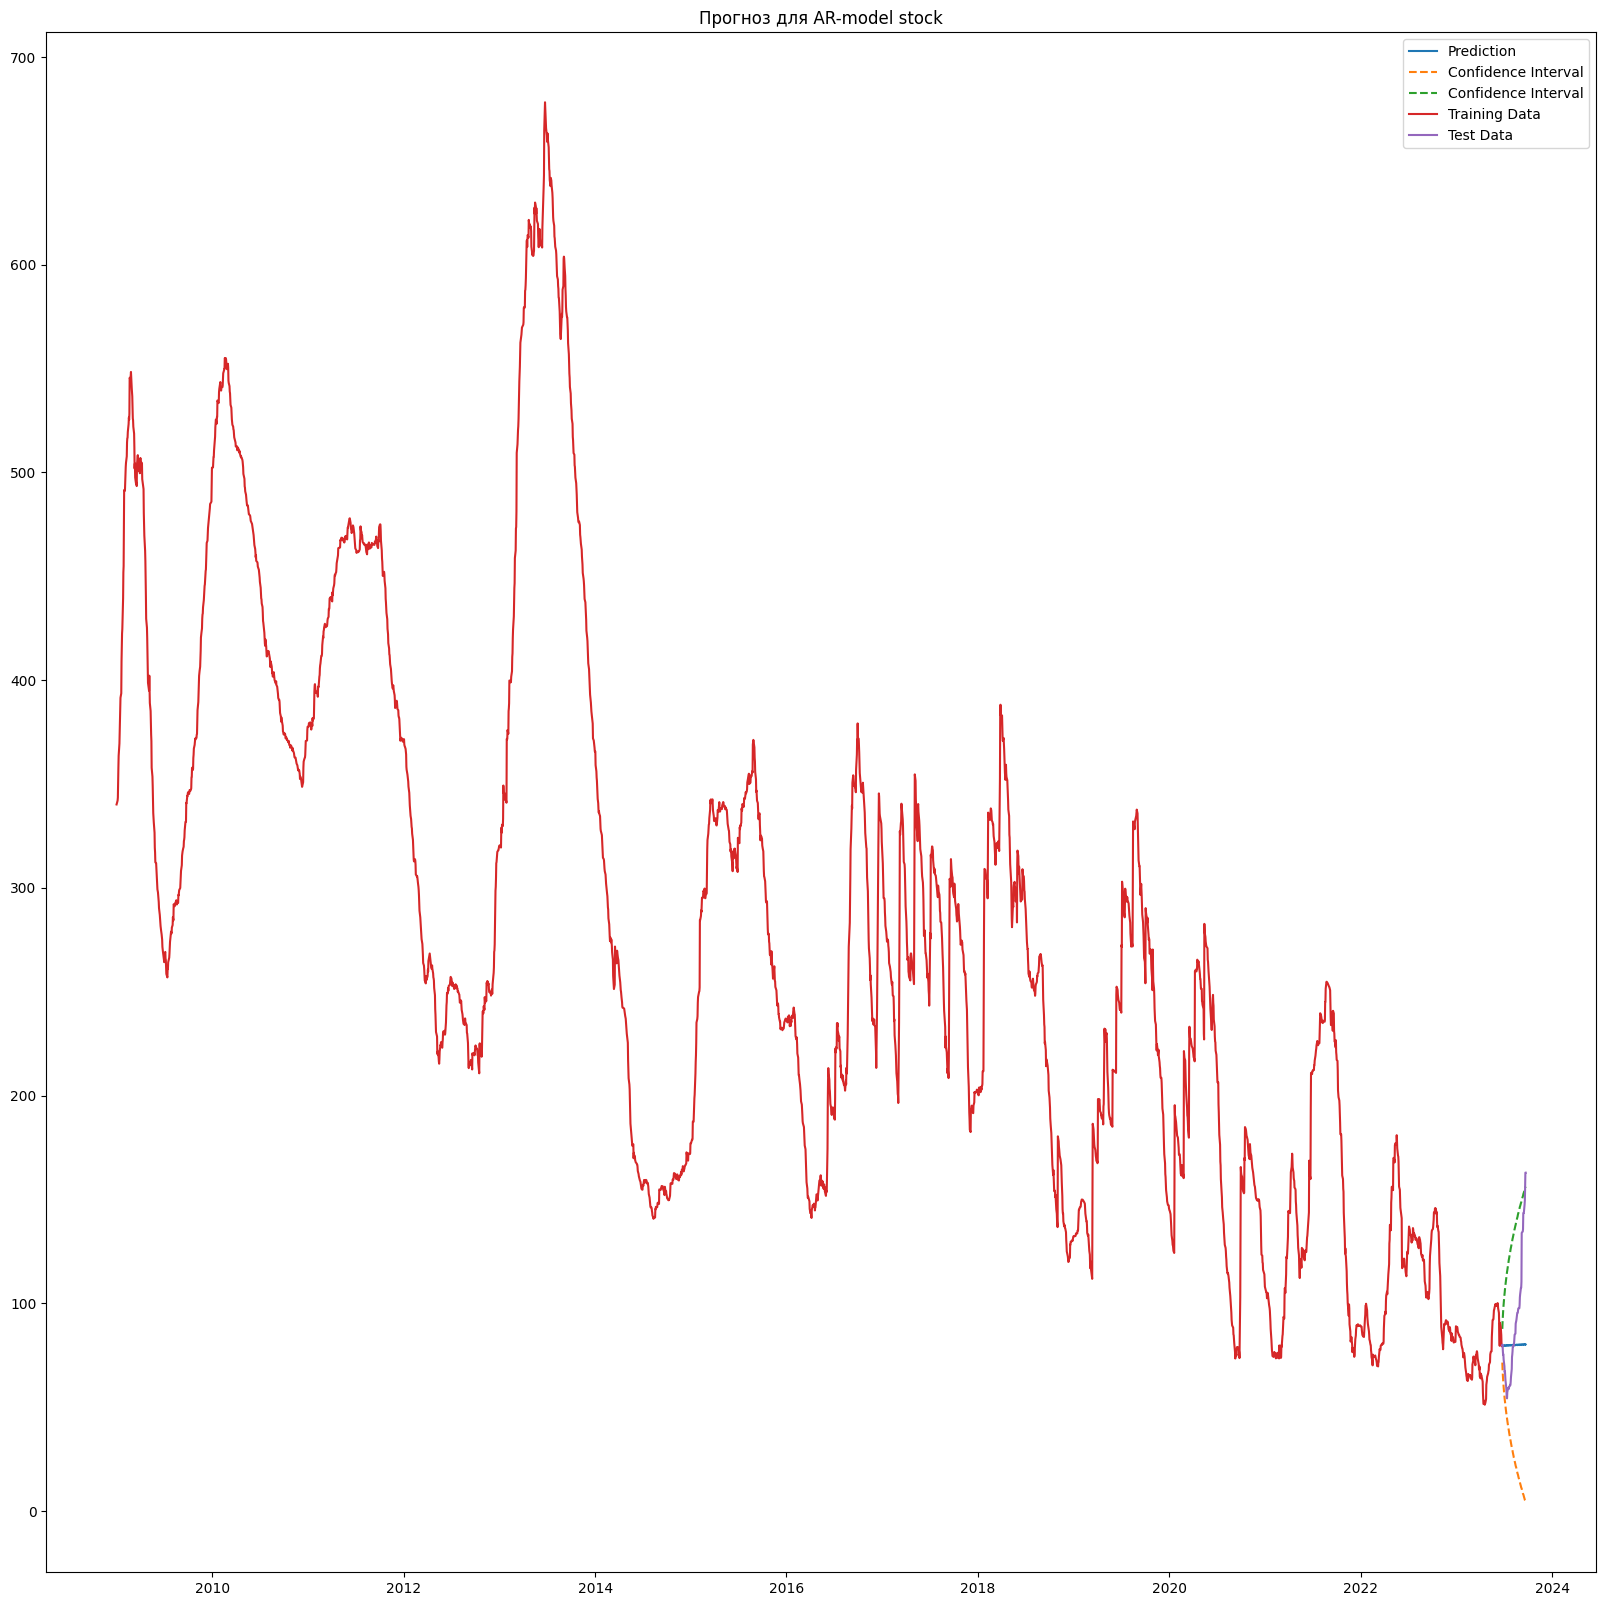

In [27]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_ar_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

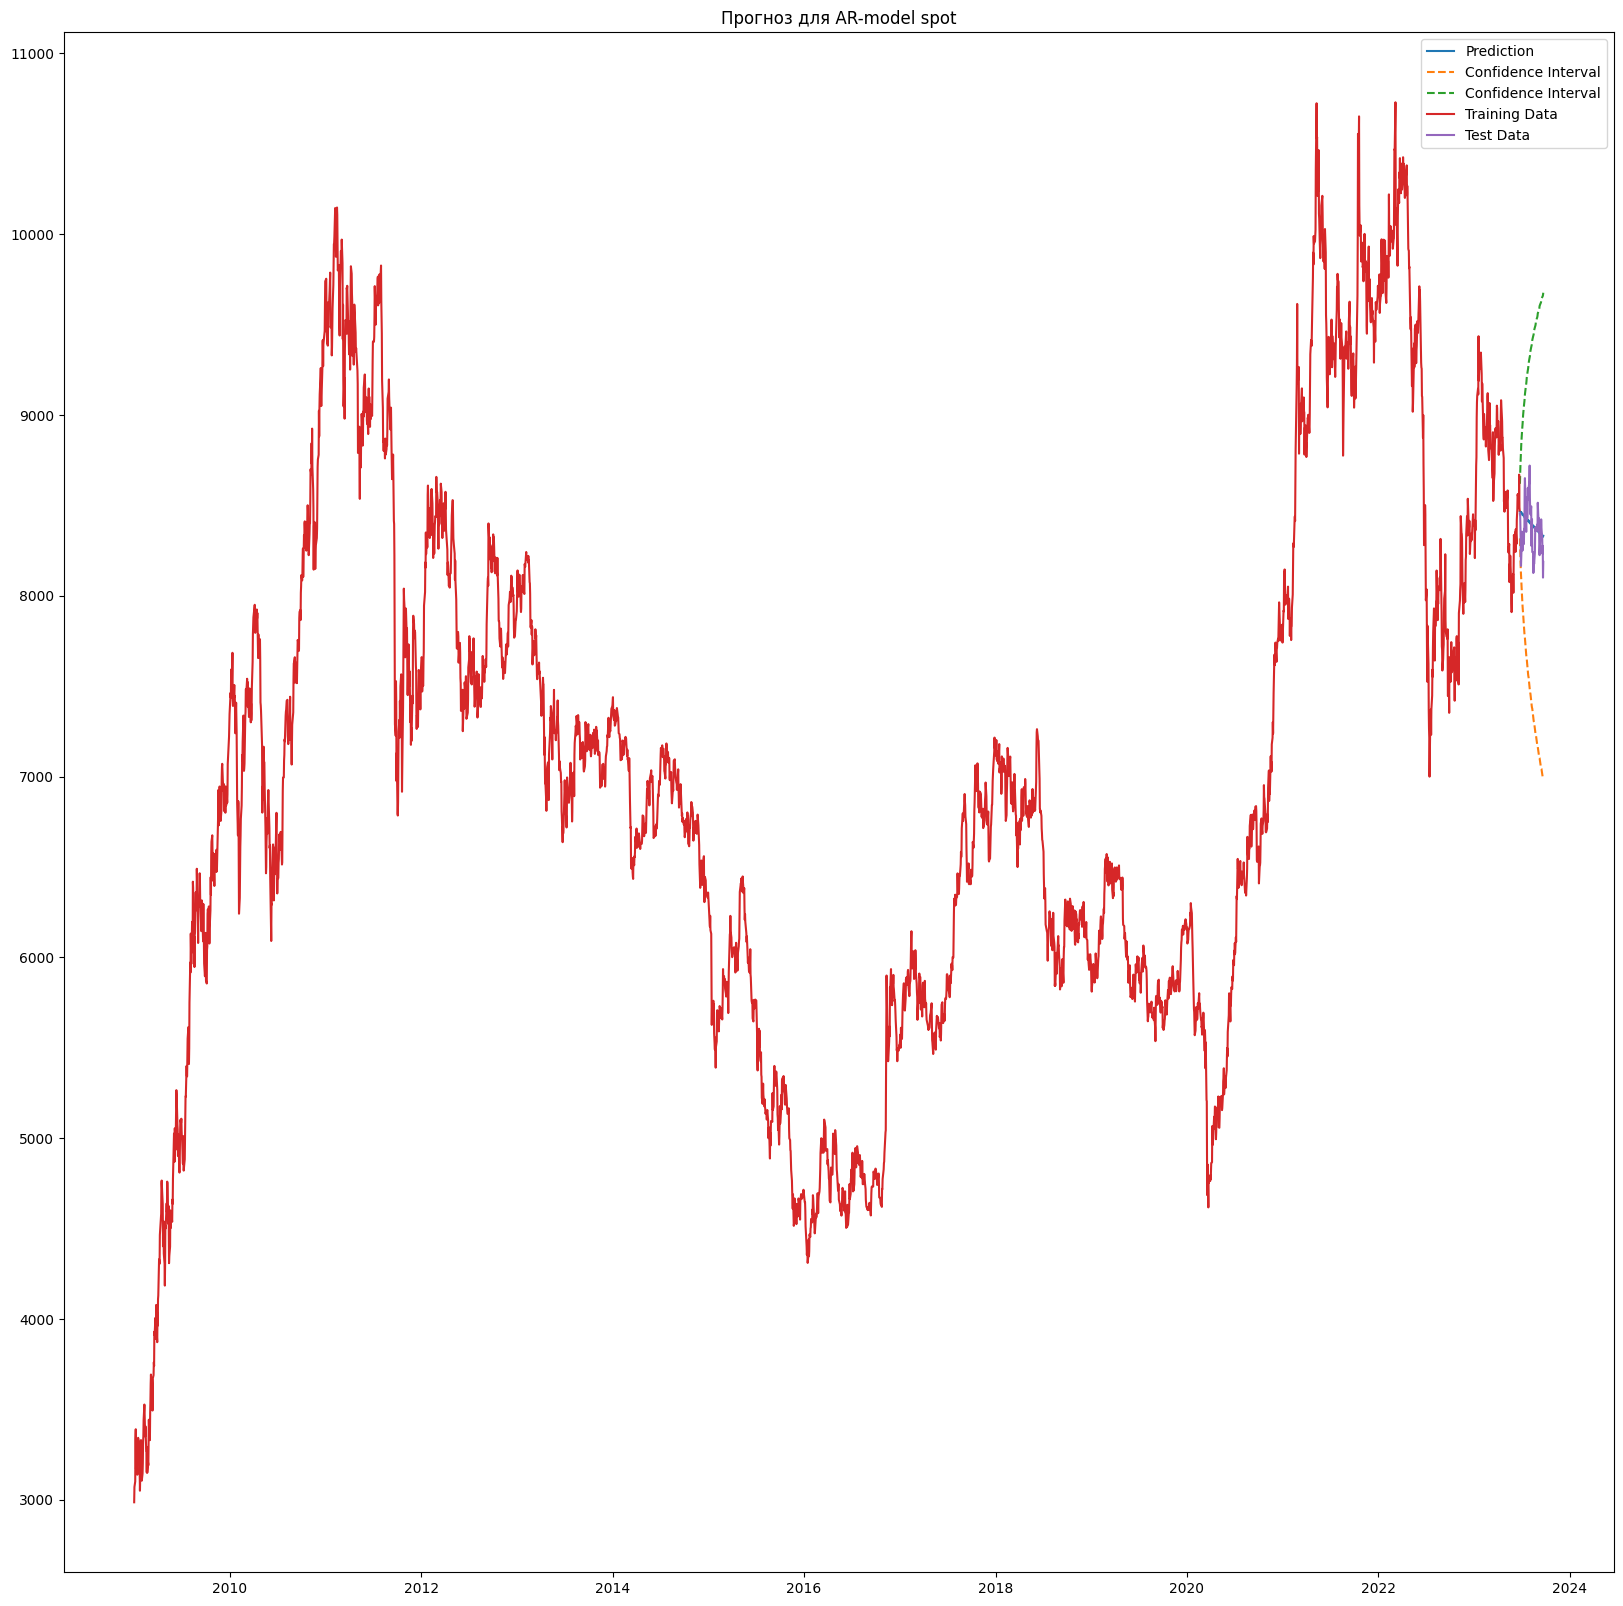

In [28]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_ar_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

> Так же стоти отметить следующее:
 * Прогноз не уловил дисперисю
 * 95% доверительный интервал весьмаширок
> Что говорит о вероято слабой прогностической способности в бою.

---

### ARIMA прогноз (т.к. ряды изначально не стационарны их порядок дифференцирования равен 1 - d=1)

In [29]:
# Используем модель ARIMA
arima_model_stock = ARIMA(train_stock, order=(p_stock, d_stock, q_stock)).fit()
arima_model_spot = ARIMA(train_spot, order=(p_spot, d_stock, q_stock)).fit()

# Прогноз
pred_arima_stock = arima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_arima_spot = arima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Модификация прогноза
pred_arima_stock = pred_arima_stock + stock_seasonal_mod + stock_resid_mod

pred_arima_spot = pred_arima_spot + spot_seasonal_mod + spot_resid_mod

# Доверительные интервалы
forecast_stock = arima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = arima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


In [30]:
# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(test_stock, pred_arima_stock, name='ARIMA-stock'))
log_metrics_spot(metrics_calculation(test_spot, pred_arima_spot, name='ARIMA-spot'))

RMSE для ARIMA-stock: 31.177
MAE для ARIMA-stock: 23.041
MAPE для ARIMA-stock: 23.599999999999998%


RMSE для ARIMA-spot: 157.52
MAE для ARIMA-spot: 132.237
MAPE для ARIMA-spot: 1.6%




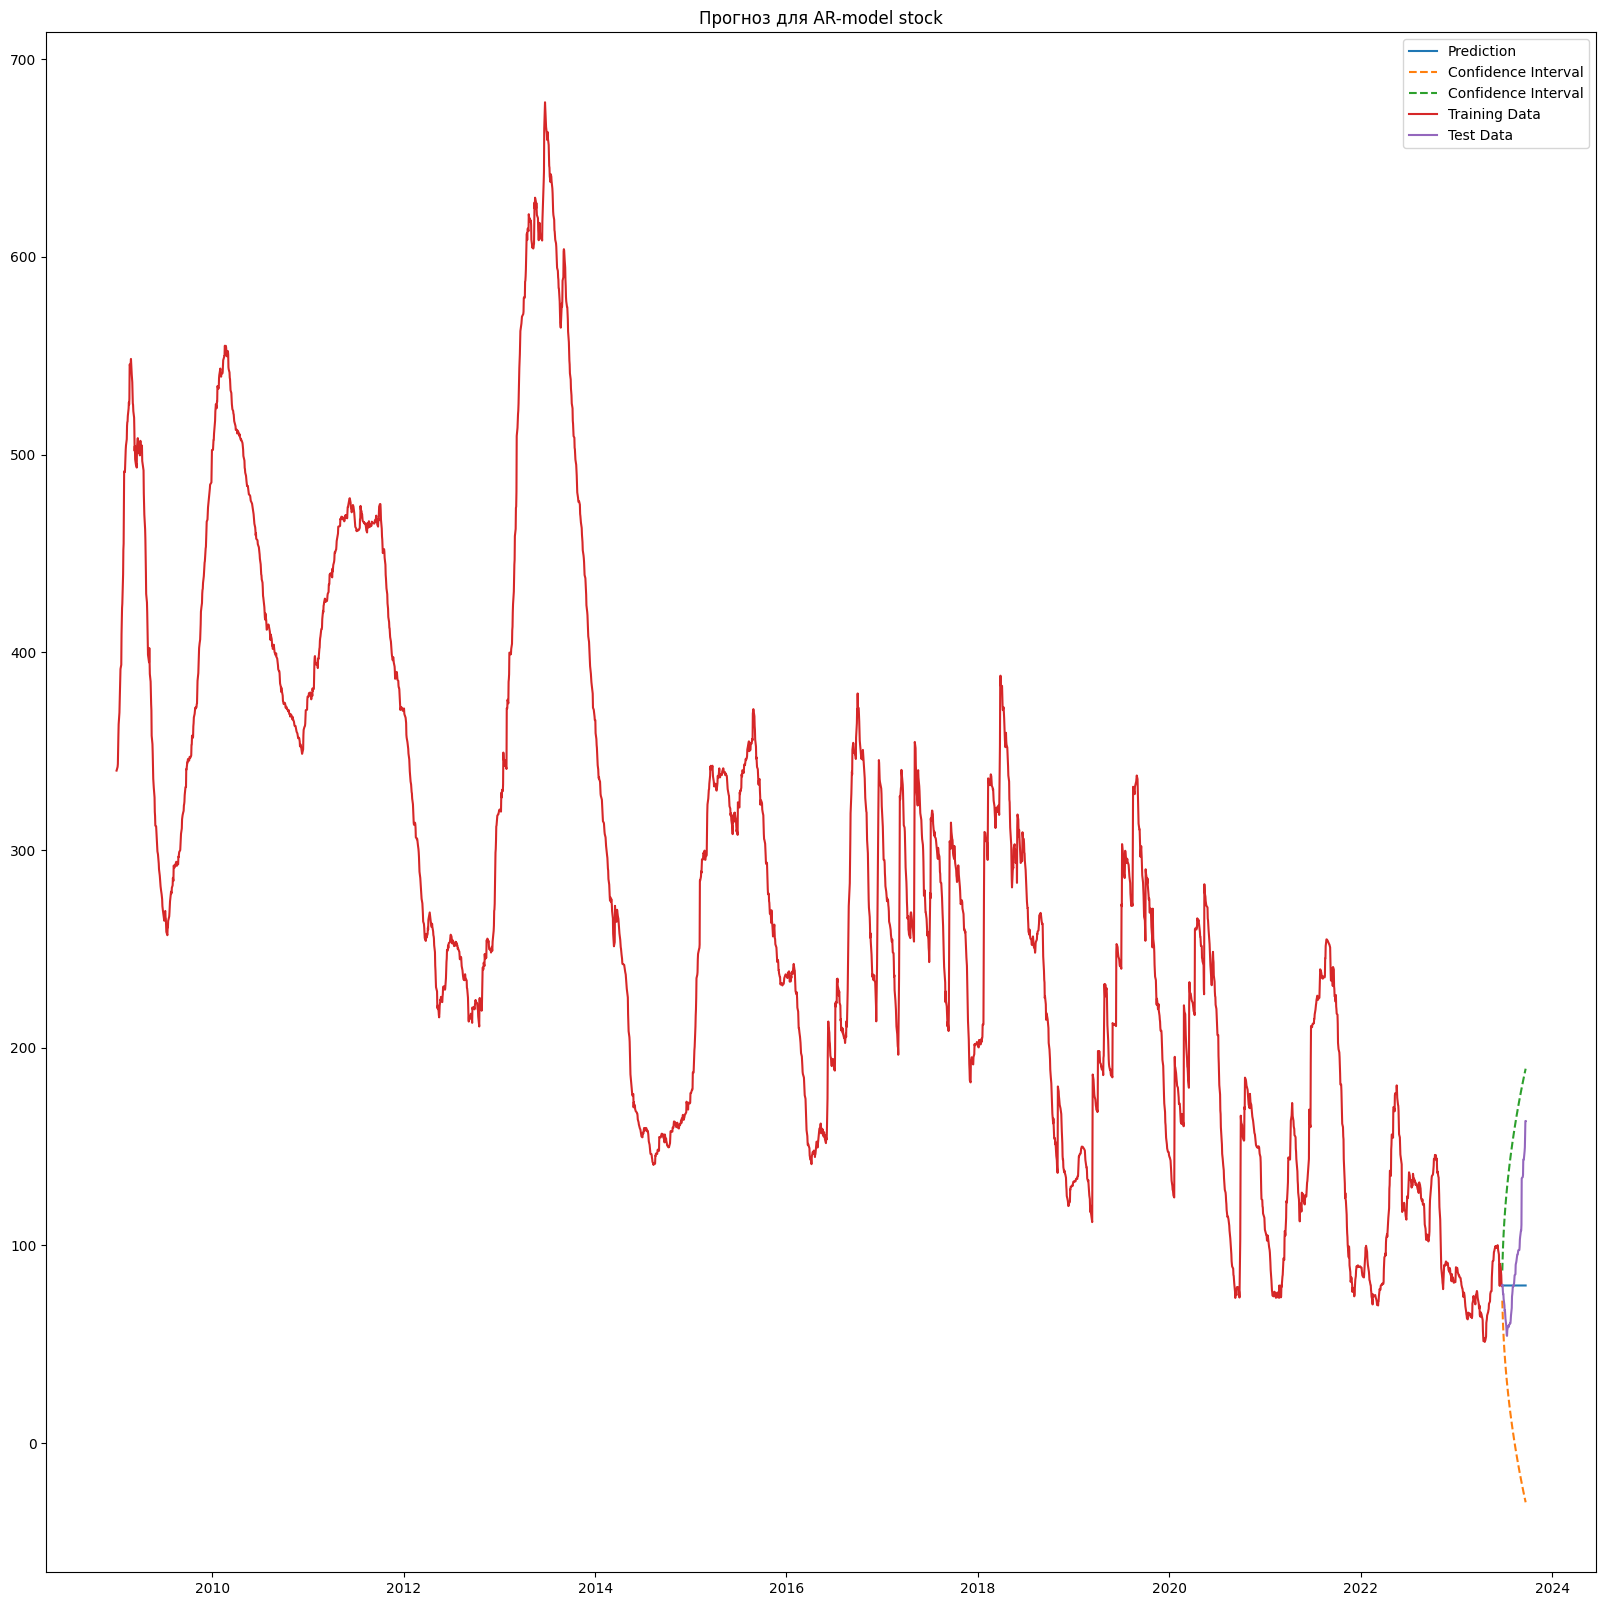

In [31]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_arima_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

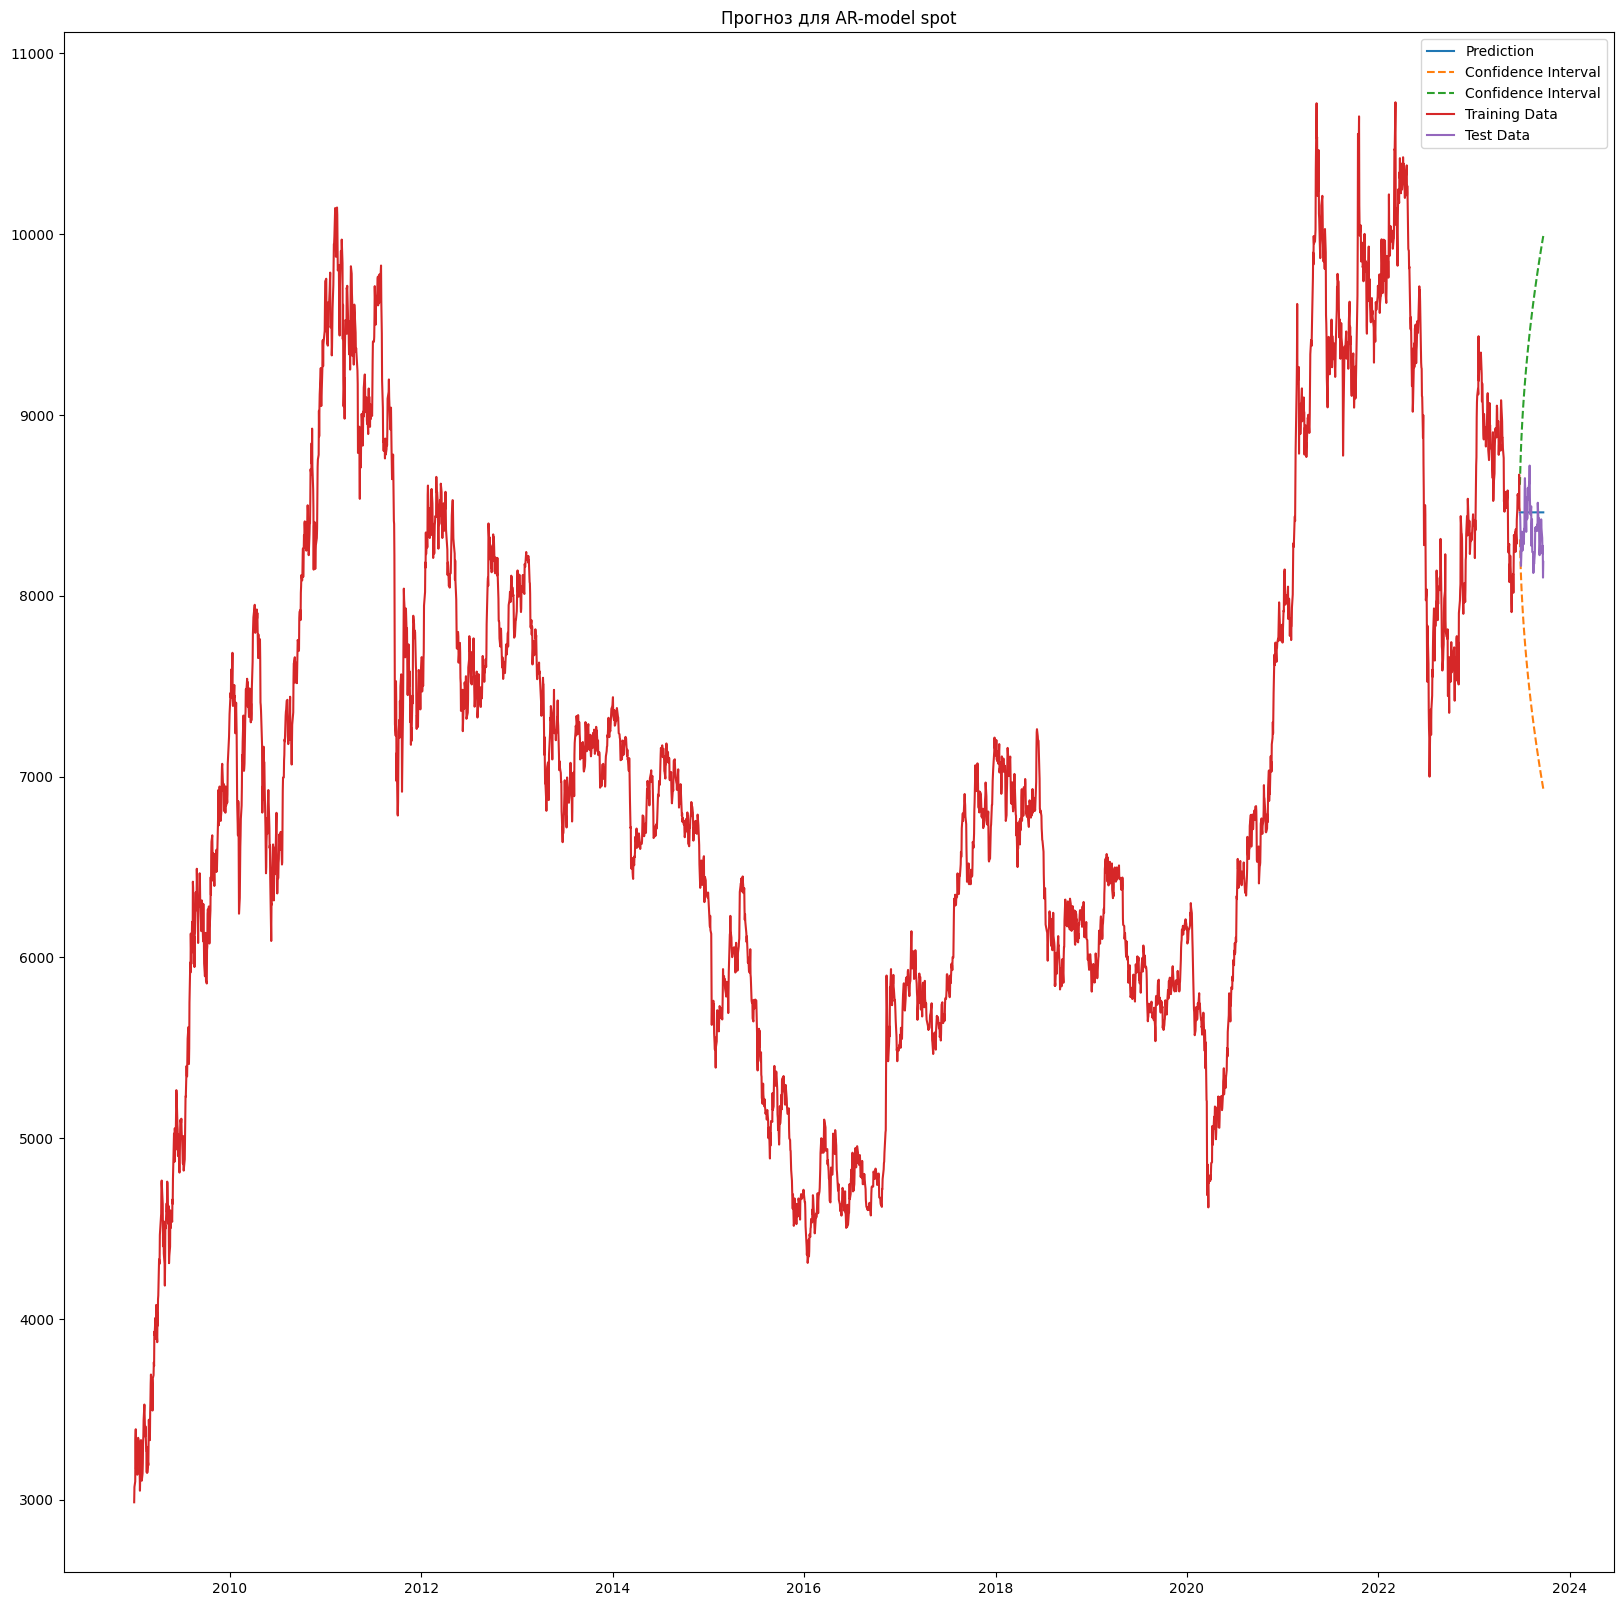

In [32]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_arima_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> В сравнение с baseline моделью произошло незначительное падение метрики spot-price, и незначительное увеличение stocks, графики так же отражают весьма сомнительную прогностическую способность для дневного анализа, НО, и это важно подчеркнуть, так как нашей задачей является СРЕДНЯЯ ЦЕНА за тестовый период, можно сказать, что задача, исходя из проделанного на данный момент анализа, вполне достижима

> Так же отсутсвует чувствительность по дисеперсии и гигантские доверительные интервалы.

---

### PMDARIMA прогноз, попробуем подобрать внутренние параметры модели автоматом.

In [33]:
model_stock = pm.auto_arima(
    train_stock, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stock.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.94 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=33009.580, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=31090.986, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=3.42 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=32542.705, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=30606.880, Time=1.18 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=8.46 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=31109.147, Time=0.88 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=30554.280, Time=1.33 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=31053.784, Time=0.80 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=9.93 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=4.51 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=30549.330, Time=1.60 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=31051.434, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 5288
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 7)   Log Likelihood              -15268.005
Date:                            Sat, 23 Sep 2023   AIC                          30546.010
Time:                                    10:46:54   BIC                          30578.868
Sample:                                01-01-2009   HQIC                         30557.494
                                     - 06-24-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6111      0.021     28.708      0.000       0.569       0.653
ma.L1         -0.3442      0.024    -14.220      0.000      -0.392      -0.297
ar.S.L7       -0.6434      0.005   -127.141      0.000      -0.653      -0.633
ar.S.L14      -0.3029      0.005    -58.309      0.000      -0.313      -0.293
sigma2        19.0072      0.084    225.407      0.000      18.842      19.172
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            309459.34
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.99   Skew:                             3.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
model_spot = pm.auto_arima(
    train_spot, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_spot.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.48 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=64519.807, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=62937.343, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=64513.349, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=62306.465, Time=1.68 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.78 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=62308.477, Time=0.60 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=62296.001, Time=1.74 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=62925.421, Time=1.05 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=5.69 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.79 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=62297.781, Time=2.33 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=62297.668, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5288
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -31143.001
Date:                           Sat, 23 Sep 2023   AIC                          62296.001
Time:                                   10:47:40   BIC                          62328.860
Sample:                               01-01-2009   HQIC                         62307.486
                                    - 06-24-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0262      0.009      2.900      0.004       0.008       0.044
ar.L2          0.0486      0.011      4.344      0.000       0.027       0.071
ar.S.L7       -0.6810      0.008    -82.133      0.000      -0.697      -0.665
ar.S.L14      -0.3364      0.008    -40.935      0.000      -0.353      -0.320
sigma2      7770.8852     82.344     94.371      0.000    7609.494    7932.277
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5380.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model_stock.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [36]:
model_spot.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

---

#### До этого момента я не сравнивал модели по критерию AIC ввиду того что по итогу все равно бы начал перебирать внутренние параметры для последующего использования SARIMAX


### ARIMA - по подобранным параметрам

In [37]:
order_stock = model_stock.order
seasonal_order_stock = model_stock.seasonal_order

order_spot = model_spot.order
seasonal_order_spot = model_spot.seasonal_order

In [38]:
# Используем модель ARIMA
pmarima_model_stock = ARIMA(
    train_stock, order=order_stock,
    seasonal_order=seasonal_order_stock).fit()

pmarima_model_spot = ARIMA(
    train_spot, order=order_spot,
    seasonal_order=seasonal_order_spot).fit()

# Прогноз
pred_pmarima_stock = pmarima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_pmarima_spot = pmarima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Доверительные интервалы
forecast_stock = pmarima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = pmarima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_pmarima_stock, name='PMARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_pmarima_spot, name='PMARIMA-spot'))

RMSE для PMARIMA-stock: 86.839
MAE для PMARIMA-stock: 64.64
MAPE для PMARIMA-stock: 60.0%


RMSE для PMARIMA-spot: 362.958
MAE для PMARIMA-spot: 312.417
MAPE для PMARIMA-spot: 3.8%




---

### SARIMAX

In [39]:
# Инициализация модели
sarimax_model_stock = SARIMAX(
    train_stock, order=order_stock, seasonal_order=seasonal_order_stock).fit()

sarimax_model_spot = SARIMAX(
    train_spot, order=order_spot, seasonal_order=seasonal_order_spot).fit()

# Спрогнозируем
pred_sarimax_stock = sarimax_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_sarimax_spot = sarimax_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Построим доверительные интервалы 
forecast_stock = sarimax_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = sarimax_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_sarimax_stock, name='SARIMAX-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_sarimax_spot, name='SARIMAX-spot'))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91863D+00    |proj g|=  5.91244D-02


 This problem is unconstrained.



At iterate    5    f=  2.88739D+00    |proj g|=  6.22906D-03

At iterate   10    f=  2.88729D+00    |proj g|=  5.19308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.916D-06   2.887D+00
  F =   2.8872929061231307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92785D+00    |proj g|=  7.46908D-03

At iterate    5    f=  5.92353D+00    |proj g|=  4.74822D-02

At iterate   10    f=  5.89007D+00    |proj g|=  3.08408D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   7.437D-06   5.889D+00
  F =   5.8893722995411277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE для SARIMAX-stock: 86.839
MAE для SARIMAX-stock: 64.64
MAPE для S

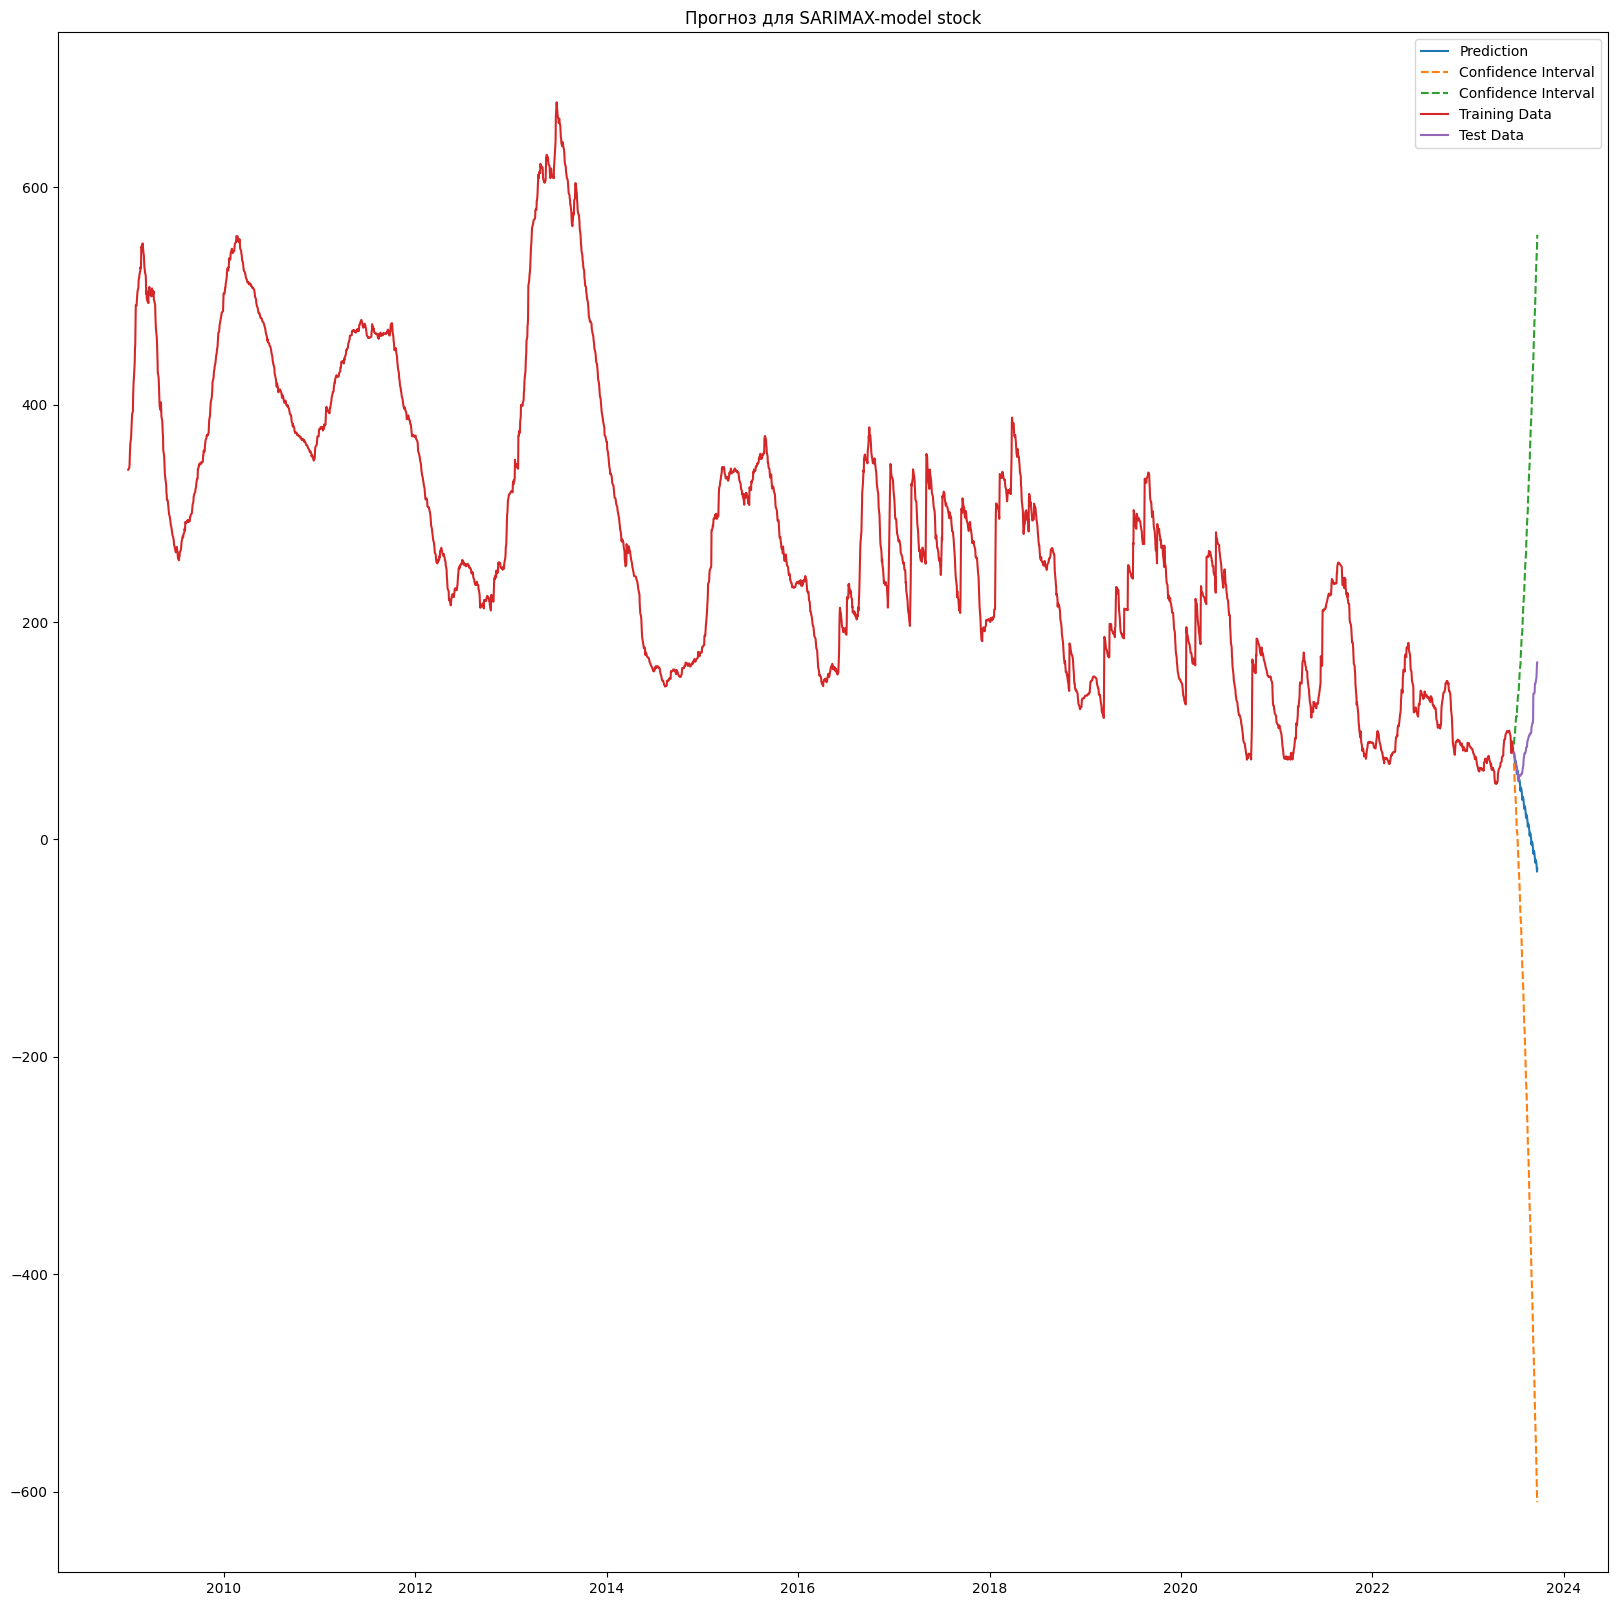

In [40]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_sarimax_stock, conf_stock,
    train_stock, test_stock, name='SARIMAX-model stock'
)

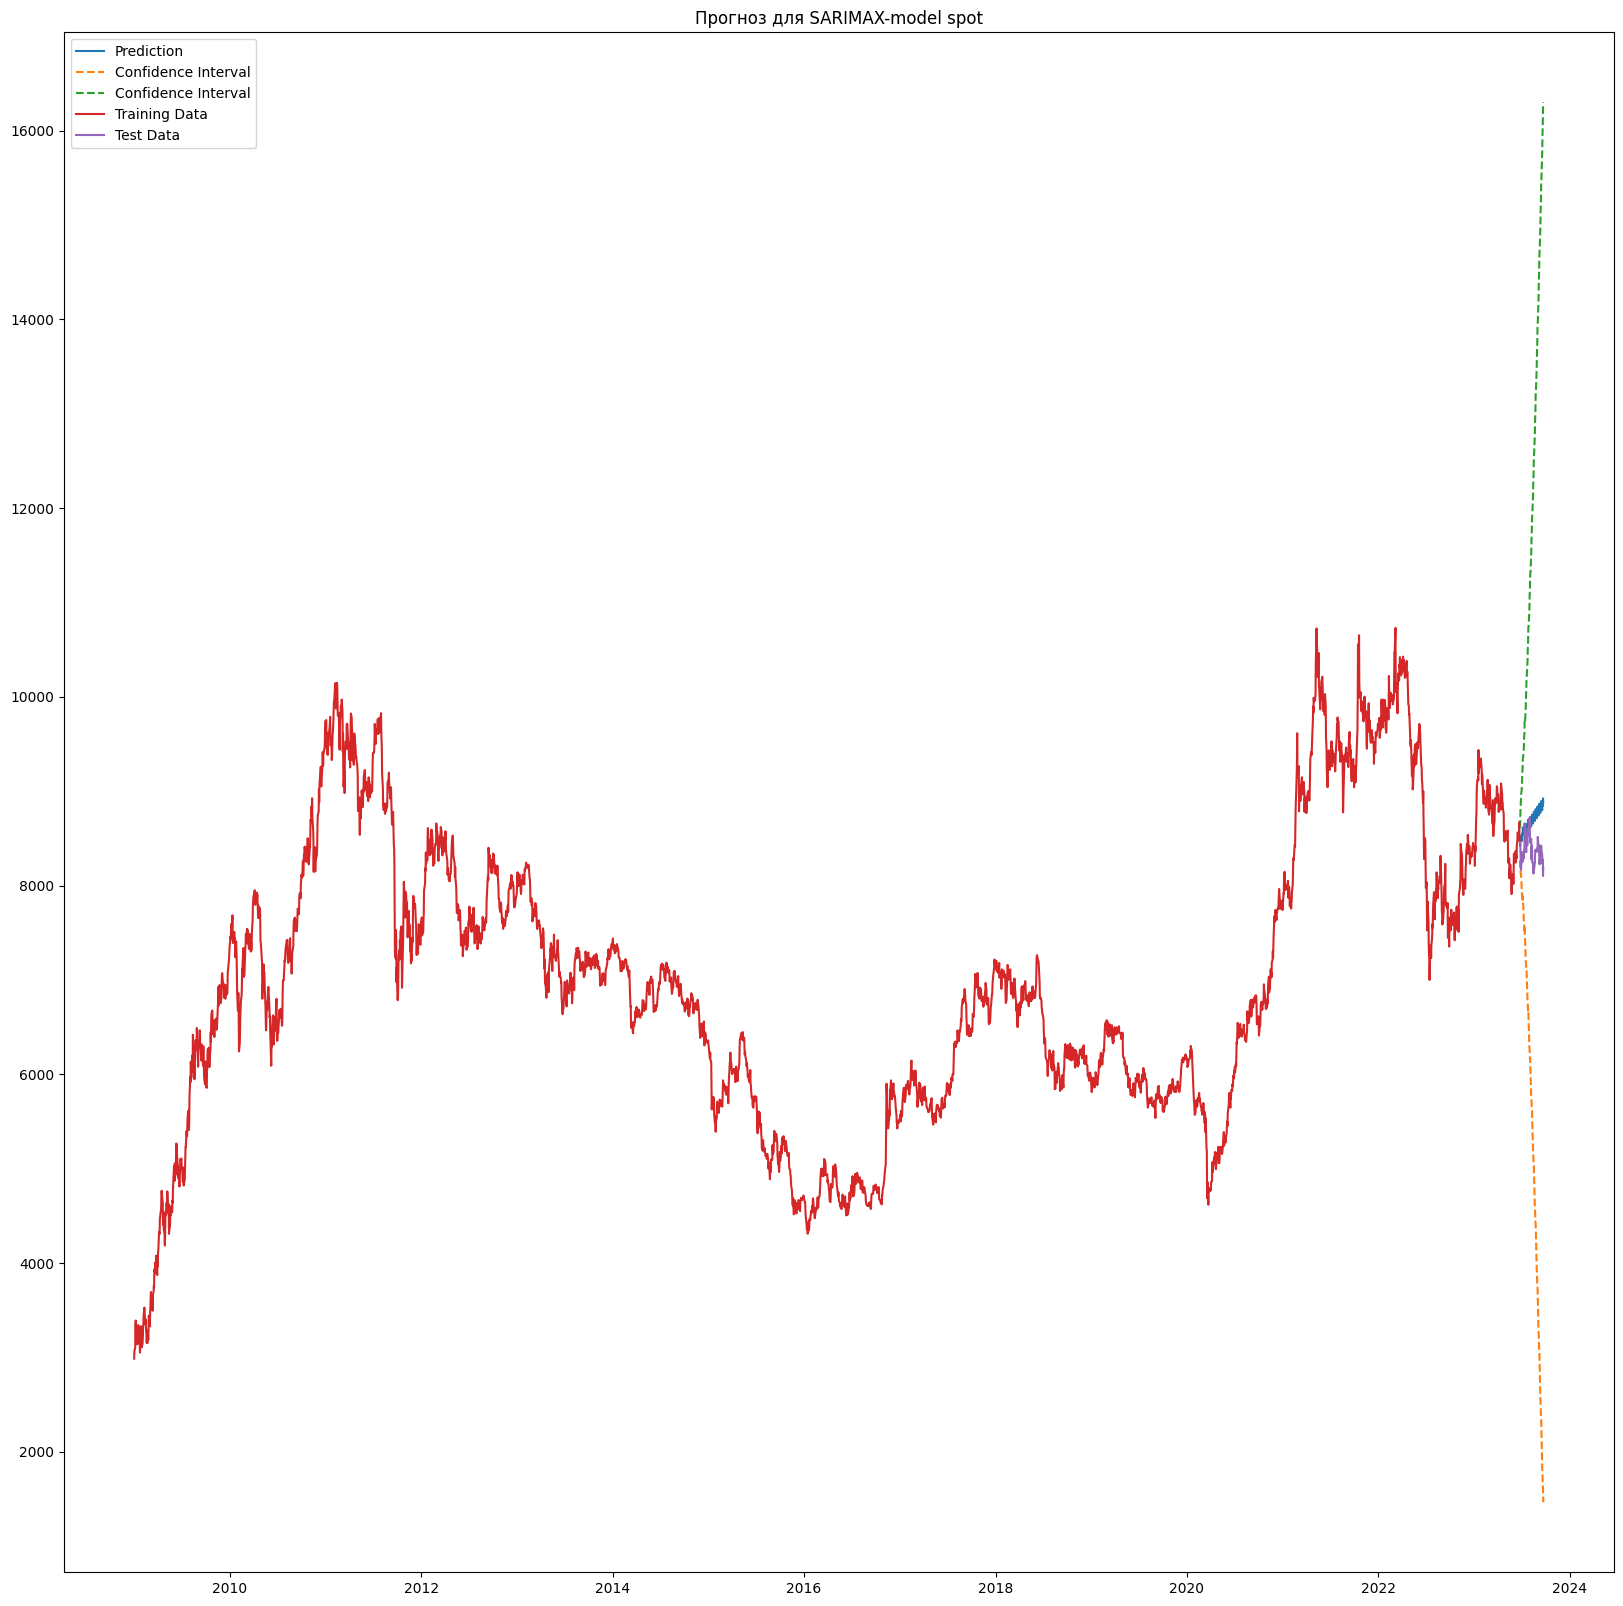

In [41]:
fig = plt.figure(figsize=(20,20))
visualisation_prog(
    pred_sarimax_spot, conf_spot,
    train_spot, test_spot, name='SARIMAX-model spot'
)

> Вывод: SARIMAX показал наихудшие результаты, возможно причина заключается в интерполированных данных, либо же влиянии экзогенных факторов не учитываемых в данном анализе (напоминаю нам необходимо разработать легковесный бенчмарк для LME для расчета среднеквартальной цены)

---

### GARCH прогноз для гетероскедастичного ряда.

In [42]:
# Инициализируем модель
garch_stock = arch_model(
    train_stock, lags=1, vol='GARCH',
    p=1, q=1, rescale=True).fit()

garch_spot = arch_model(
    train_spot, lags=1, vol='GARCH',
    p=2, q=1, rescale=True).fit()

# Сделаем предсказание
pred_garch_stock = garch_stock.forecast(
    start=str(train_stock.index[-1]), horizon=90)
pred_garch_spot = garch_spot.forecast(
    start=str(train_spot.index[-1]), horizon=90)

forecast_values = pred_garch_spot.mean.values[-1, :]
for i in range(len(test_spot)):
    print(
        f"Фактическое значение: {test_spot[i]}, Прогнозное значение: {forecast_values[i]}")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 671131441824.2927
Iteration:      2,   Func. Count:     13,   Neg. LLF: 29811.817575704816
Iteration:      3,   Func. Count:     19,   Neg. LLF: 58450.69065298181
Iteration:      4,   Func. Count:     26,   Neg. LLF: 21401.54785512946
Iteration:      5,   Func. Count:     32,   Neg. LLF: 18145.882712273295
Iteration:      6,   Func. Count:     37,   Neg. LLF: 18476.89935202564
Iteration:      7,   Func. Count:     47,   Neg. LLF: 18360.330320020505
Iteration:      8,   Func. Count:     53,   Neg. LLF: 18023.365300170422
Iteration:      9,   Func. Count:     59,   Neg. LLF: 18089.72222299586
Iteration:     10,   Func. Count:     65,   Neg. LLF: 18015.302552048644
Iteration:     11,   Func. Count:     71,   Neg. LLF: 17998.675483037994
Iteration:     12,   Func. Count:     77,   Neg. LLF: 17996.552040505034
Iteration:     13,   Func. Count:     82,   Neg. LLF: 17996.161856180042
Iteration:     14,   Func. Count:     87,   Neg. LLF: 17

> meh...

---

### Перед тем как перейти кследующей части, произведем небольшую манипуляцию с данными для проверки модели с включением экзогенных факторов (для нас это фьючерсы).

In [43]:
# Посмотри на лучшую модель для запасов
results = pd.read_csv('./data/errors/stock.csv')
min_index = results[['rmse', 'mae']].idxmin()
min_row = results.loc[min_index]
min_row['model_name'].mode()

0    AR-baseline-stock
1          ARIMA-stock
Name: model_name, dtype: object

In [44]:
# И для spota
results = pd.read_csv('./data/errors/spot.csv')
min_index = results[['rmse', 'mae']].idxmin()
min_row = results.loc[min_index]
min_row['model_name'].mode()

0    AR-baseline-spot
Name: model_name, dtype: object

In [45]:
# Посмотрим на картины прогнозов для этих моделей
display(pred_ar_stock.tail(15), pred_arima_stock.tail(15))

2023-09-08    80.096164
2023-09-09    80.097780
2023-09-10    80.099030
2023-09-11    80.100264
2023-09-12    79.977610
2023-09-13    80.198945
2023-09-14    80.286361
2023-09-15    80.143871
2023-09-16    80.145474
2023-09-17    80.146710
2023-09-18    80.147930
2023-09-19    80.025262
2023-09-20    80.246584
2023-09-21    80.333986
2023-09-22    80.191483
Freq: D, dtype: float64

2023-09-08    79.70668
2023-09-09    79.70668
2023-09-10    79.70668
2023-09-11    79.70668
2023-09-12    79.70668
2023-09-13    79.70668
2023-09-14    79.70668
2023-09-15    79.70668
2023-09-16    79.70668
2023-09-17    79.70668
2023-09-18    79.70668
2023-09-19    79.70668
2023-09-20    79.70668
2023-09-21    79.70668
2023-09-22    79.70668
Freq: D, dtype: float64

In [46]:
# Выбираем модель для прогноза остатков, тут стоит отметить почему 
# выбор пал на базовую модель, дело в том, что различие в метриках 
# было не значительно, но сама картина прогнозных запасов выглядит
# реалистичнее () 
best_ts = pred_ar_stock

In [47]:
# Объединим тренировочную выборку по запасам с предсказанием в единый вектор
stock_column = pd.concat([train_stock, best_ts])
stock_column.tail(10)

2023-09-13    80.198945
2023-09-14    80.286361
2023-09-15    80.143871
2023-09-16    80.145474
2023-09-17    80.146710
2023-09-18    80.147930
2023-09-19    80.025262
2023-09-20    80.246584
2023-09-21    80.333986
2023-09-22    80.191483
dtype: float64

In [48]:
# Создадим новую рабочую выборку, она нам понадобится и на этом этапе и для дальнейшего исследования.
working_data_new = pd.concat(
    [working_data[['LME Copper Cash-Settlement', 'LME Copper 3-month']], stock_column],
    axis=1).rename(columns={0: 'LME Copper Stock'})

display(working_data.head(), working_data.tail())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2009-01-01,2986.500000,5885.000000,340.1625
2009-01-02,3071.000000,5793.666667,340.5500
2009-01-03,3081.166667,5702.333333,341.0500
2009-01-04,3091.333333,5611.000000,341.5500
2009-01-05,3101.500000,5630.000000,342.0500


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-18,8320.0,8550.000000,147.575
2023-09-19,8233.5,8498.000000,149.600
2023-09-20,8277.0,8668.000000,155.700
2023-09-21,8101.0,8478.000000,162.900
2023-09-22,8188.0,8459.333333,162.900


In [49]:
# Сформируем трейн/тест для общего случая
train = working_data_new[:len(train_spot)]
test = working_data_new[-len(test_spot):]


In [50]:
# Тренировочная эндогенная
endog_train = train.iloc[:,0]
# Небольшой пердолинг для экзогенных
exog_train = train.iloc[:,1:]
exog_test = test.iloc[:,1:]
#exog_train = pd.concat([exog_train, exog_test], axis=0)

# Тестовая выборка
endog_test = test.iloc[:,0]

# Горизонт планирования
start = str(endog_test.index.min())
end = str(endog_test.index.max())

In [51]:
# Инициализируем модель, порядок p,d,q возьмем из предлагаемых pdarima
arimax_model_spot = ARIMA(endog_train, exog=exog_train, order=order_spot).fit()

In [52]:
# Спрогнозируем
pred_arimax_spot = arimax_model_spot.predict(start=start, end=end, exog=exog_test)

In [53]:
log_metrics_spot(metrics_calculation(pred_arimax_spot, endog_test, name='ARIMAX-spot'))

RMSE для ARIMAX-spot: 153.848
MAE для ARIMAX-spot: 128.713
MAPE для ARIMAX-spot: 1.5%




> Вывод: Неплохой показатель, но все равно хуже чем у baseline модели

---

## Часть 2.

### В данной части мы возьмем модель предсказашую наилучший результат (на рассматриваемых метриках) для остатках запасов, затем используем вектор предсказания как фиты для моделей линейной регрессии, сравним с тестовой выборкой и оценим результат с лучшим результатом для прогноза спотовой цены полученного с помощью анализа временных рядов.

In [285]:
exp_train = train.reset_index(names='date')
exp_test = test.reset_index(names='date')

# Перекодируем дату
def date_format_reverse(date):
    date = datetime.strptime(
    str(date),
    "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)

exp_train['date'] = exp_train['date'].apply(date_format_reverse)
exp_test['date'] = exp_test['date'].apply(date_format_reverse)

In [286]:
# Сформируем трейн/тест
X_train = exp_train.drop(exp_train.columns.tolist()[1], axis=1)
y_train = exp_train[exp_train.columns.tolist()[1]]

X_test = exp_test.drop(exp_test.columns.tolist()[1], axis=1)
y_test = exp_test[exp_test.columns.tolist()[1]]

---

#### Linear Regression

In [287]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

pred_lr_model = lr_model.predict(X_test)
pred_lr_model = pd.Series(pred_lr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_lr_model, name='LR-model'))

RMSE для LR-model: 278.831
MAE для LR-model: 219.534
MAPE для LR-model: 2.6%


Дубликат значения metric. Не сохраняем.


---

#### Decision Tree regressor

In [288]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [289]:
dt_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)
dt_model.fit(X_train, y_train)

pred_dt_spot = dt_model.predict(X_test)
pred_dt_spot = pd.Series(pred_dt_spot, index=test.index)
log_metrics_spot(metrics_calculation(y_test, pred_dt_spot, name='DT-model'))

RMSE для DT-model: 161.643
MAE для DT-model: 128.256
MAPE для DT-model: 1.5%


Дубликат значения metric. Не сохраняем.


#### Decision Tree regressor (only futures)

In [240]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_s = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_s.fit(X_train.iloc[:,:-1], y_train)
grid_search_dt_s.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [241]:
dt_model_s = DecisionTreeRegressor(
    **grid_search_dt_s.best_params_,
    random_state=42
)
dt_model_s.fit(X_train.iloc[:,:-1], y_train)

pred_dt_spot_s = dt_model_s.predict(X_test.iloc[:,:-1])
pred_dt_spot_s = pd.Series(pred_dt_spot_s, index=test.index)
log_metrics_spot(metrics_calculation(y_test, pred_dt_spot_s, name='DT_simple-model'))

RMSE для DT_simple-model: 347.078
MAE для DT_simple-model: 318.435
MAPE для DT_simple-model: 3.8%




#### Decision Tree regressor (for stock)

In [242]:
X_train_stock = X_train.drop(X_train.columns.to_list()[-1], axis=1)
X_test_stock = X_test.drop(X_test.columns.to_list()[-1], axis=1)

y_train_stock = X_train[X_train.columns.to_list()[-1]]
y_test_stock = X_test[X_test.columns.to_list()[-1]]

In [243]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_ss = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_ss.fit(X_train_stock, y_train_stock)
grid_search_dt_ss.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [244]:
dt_model_s = DecisionTreeRegressor(
    **grid_search_dt_ss.best_params_,
    random_state=42
)
dt_model_s.fit(X_train_stock, y_train_stock)

pred_dt_spot_ss = dt_model_s.predict(X_test_stock)
pred_dt_spot_ss = pd.Series(pred_dt_spot_ss, index=test.index)
log_metrics_spot(metrics_calculation(y_test_stock, pred_dt_spot_ss, name='DT-model'))

RMSE для DT-model: 29.668
MAE для DT-model: 24.374
MAPE для DT-model: 29.2%


Дубликат значения metric. Не сохраняем.


---

#### RandomForestRegressor для spot-price на основе только фючерсов.

In [245]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_srfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_srfr.fit(X_train.iloc[:,:2], y_train)
grid_search_srfr.best_params_

{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}

In [246]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
srfr_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

srfr_model.fit(X_train.iloc[:,:2], y_train)

pred_srfr_model = srfr_model.predict(X_test.iloc[:,:2])
pred_srfr_model = pd.Series(pred_srfr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_srfr_model, name='RFR-model_no_stock'))

RMSE для RFR-model_no_stock: 149.288
MAE для RFR-model_no_stock: 117.606
MAPE для RFR-model_no_stock: 1.4000000000000001%


Дубликат значения metric. Не сохраняем.


---

#### RandomForestRegressor для spot-price на основе спрогнозированных запасов.

In [247]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_

{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}

In [248]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

rfr_model.fit(X_train, y_train)

pred_rfr_model = rfr_model.predict(X_test)
pred_rfr_model = pd.Series(pred_rfr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_rfr_model, name='RFR-model'))

RMSE для RFR-model: 190.129
MAE для RFR-model: 156.467
MAPE для RFR-model: 1.9%


Дубликат значения metric. Не сохраняем.


#### RandomForestRegressor для stock.

In [249]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr_s = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr_s.fit(X_train_stock, y_train_stock)
grid_search_rfr_s.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

In [250]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model_s = RandomForestRegressor(
    **grid_search_rfr_s.best_params_,
    random_state=42,
)

rfr_model_s.fit(X_train_stock, y_train_stock)

pred_rfr_model_s = rfr_model_s.predict(X_test_stock)
pred_rfr_model_s = pd.Series(pred_rfr_model_s, index=test.index)

log_metrics_stock(metrics_calculation(y_test_stock, pred_rfr_model_s, name='RFR-model'))

RMSE для RFR-model: 30.198
MAE для RFR-model: 23.046
MAPE для RFR-model: 24.7%


Дубликат значения metric. Не сохраняем.


> Вывод: Как можно наблюдать, использование остатков было не плохой идеей, при том лучший результат показала модель со сформированными base-line моделью остатками, но итоговые метрики хуже чем ARIMA или AR-baseline.

----

### Gradient_boost stock + futures

In [251]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf':[1, 2, 3, 4, 5]
}

grid_search_gbr = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr.fit(X_train, y_train)
grid_search_gbr.best_params_

{'learning_rate': 0.1,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [259]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)

gbr_model.fit(X_train, y_train)

pred_gbr_model = gbr_model.predict(X_test)
pred_gbr_model = pd.Series(pred_gbr_model, test.index)

log_metrics_spot(metrics_calculation(y_test, pred_gbr_model, name='GBR-model_full'))

RMSE для GBR-model_full: 206.852
MAE для GBR-model_full: 165.687
MAPE для GBR-model_full: 2.0%




#### GradBoost for stock

In [253]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf':[1, 2, 3, 4, 5]
}

grid_search_gbr_s = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr_s.fit(X_train_stock, y_train_stock)
grid_search_gbr_s.best_params_

{'learning_rate': 0.1,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 100}

In [258]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbr_model_s = GradientBoostingRegressor(
    **grid_search_gbr_s.best_params_,
    random_state=42,
)

gbr_model_s.fit(X_train_stock, y_train_stock)

pred_gbr_model_s = gbr_model_s.predict(X_test_stock)
pred_gbr_model_s = pd.Series(pred_gbr_model_s, test.index)

log_metrics_stock(metrics_calculation(y_test_stock, pred_gbr_model_s, name='GBR-model_full'))

RMSE для GBR-model_full: 31.746
MAE для GBR-model_full: 24.549
MAPE для GBR-model_full: 26.6%




----

### Gradient_boost futures

In [255]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf':[1, 2, 3, 4, 5]
}

grid_search_gbrs = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_gbrs.fit(X_train.iloc[:,:2], y_train)
grid_search_gbrs.best_params_

{'learning_rate': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [260]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbrs_model = GradientBoostingRegressor(
    **grid_search_gbrs.best_params_,
    random_state=42,
)

gbrs_model.fit(X_train.iloc[:,:2], y_train)

pred_gbrs_model = gbrs_model.predict(X_test.iloc[:,:2])
pred_gbrs_model = pd.Series(pred_gbrs_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_gbrs_model, name='GBR-model_futures'))

RMSE для GBR-model_futures: 285.93
MAE для GBR-model_futures: 249.814
MAPE для GBR-model_futures: 3.0%


Дубликат значения metric. Не сохраняем.


---

### Stacking

In [264]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model), 
    ('Decision Tree', decsion_tree_model),('GradientBoosting', gbr_model)] 

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor.fit(X_train, y_train)

# Получаем предсказания
predictions = stacking_regressor.predict(X_test)

log_metrics_spot(metrics_calculation(y_test, predictions, name='Stacking'))

RMSE для Stacking: 326.53
MAE для Stacking: 255.873
MAPE для Stacking: 3.1%


Дубликат значения metric. Не сохраняем.


#### Stacking for stock

In [265]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt_ss.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_rfr_s.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr_s.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model), 
    ('Decision Tree', decsion_tree_model),('GradientBoosting', gbr_model)] 

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor_s = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor_s.fit(X_train_stock, y_train_stock)

# Получаем предсказания
predictions_s = stacking_regressor_s.predict(X_test_stock)

log_metrics_stock(metrics_calculation(y_test_stock, predictions_s, name='Stacking'))

RMSE для Stacking: 246.841
MAE для Stacking: 244.62
MAPE для Stacking: 310.3%


Дубликат значения metric. Не сохраняем.


---

## Часть 3.

### Проверка среднемесячных прогнозов

#### В реальных задачах нас интересуют средние показатели по металлу за месяц и квартал (более далекий горизонт планирования рассматривается лишь в конце года для формирования ТПФП), при том мы расчитываем реальные показатели на неинтерполированном ряду.

#### Первоначальное предположение складывалось из того, что мы понижаем точность прогноза в угоду простоте и мобильности, наша основная цель попасть в окно 250$ на спот при расчете среднемесячного и среднеквартального показателя.

#### В данном случае мы должны сравнить точность на среднемесячных для июля, августа и сентября (то что на данный момент есть), и соответсвенно для 3 квартала (с учетом не полного сентября)


In [290]:
# Посмотрим на модели показавшие наилучший результат по MAE
errors_spot = pd.read_csv('./data/errors/spot.csv', sep=',')
errors_spot.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-23 00:00:00,DT-model,2.966800e+01,2.437400e+01,29.2
1,2023-09-22 00:00:00,AR-baseline-spot,1.313110e+02,1.034880e+02,1.2
2,2023-09-23 00:00:00,AR-baseline-spot,1.300400e+02,1.038200e+02,1.2
3,2023-09-22 00:00:00,AR-baseline-spot,1.324210e+02,1.046720e+02,1.3
4,2023-09-20 00:00:00,AR-baseline-spot,1.327930e+02,1.051010e+02,1.3
...,...,...,...,...,...
72,2023-09-20 00:00:00,SARIMAX-spot,9.417520e+02,8.389770e+02,10.0
73,2023-09-20 00:00:00,SARIMAX-spot,1.215044e+03,1.082155e+03,12.9
74,2023-09-21 00:00:00,SARIMAX-spot,1.640640e+03,1.476358e+03,17.7
75,2023-09-21 00:00:00,PMARIMA-spot,1.640640e+03,1.476358e+03,17.7


In [291]:
errors_stock = pd.read_csv('./data/errors/stock.csv', sep=',')
errors_stock.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-20 00:00:00,ARIMA-stock,25.625,20.145,23.6
1,2023-09-20 00:00:00,AR-baseline-stock,25.412,20.317,24.3
2,2023-09-20 00:00:00,AR-baseline-stock,26.342,20.639,23.8
3,2023-09-20 00:00:00,ARIMA-stock,26.638,20.691,23.5
4,2023-09-21 00:00:00,AR-baseline-stock,28.212,21.028,22.6
5,2023-09-21 00:00:00,ARIMA-stock,29.098,21.398,22.3
6,2023-09-22 00:00:00,AR-baseline-stock,29.797,21.998,22.9
7,2023-09-22 00:00:00,ARIMA-stock,30.235,22.242,22.9
8,2023-09-23 00:00:00,AR-baseline-stock,30.965,22.886,23.5
9,2023-09-23 00:00:00,ARIMA-stock,31.177,23.041,23.6


In [292]:
data = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col=['date'])
data.head()

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-22,8188.0,8255.0,162.900
2023-09-21,8101.0,8170.0,162.900
2023-09-20,8277.0,8336.0,155.700
2023-09-19,8233.5,8295.0,149.600
2023-09-18,8320.0,8388.0,147.575


In [293]:
# Расчитаем истинное среднее помесячно (горизонт - 3 месяца)
real_data_m = data.reset_index().groupby(pd.Grouper(key='date', freq='M')).mean()
real_data_m = real_data_m.tail(3)

real_data_m = real_data_m.reset_index()
columns = real_data_m.columns.to_list()

real_data_m['date'] = pd.to_datetime(real_data_m['date'])
real_data_m = real_data_m.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})
real_data_m = real_data_m.iloc[:, :2]
real_data_m

,Date,LME price_real
0,2023-07-31,8445.261905
1,2023-08-31,8351.772727
2,2023-09-30,8322.218750


In [294]:
pred = pred_dt_spot
final_raw = pd.concat([train_spot, pred]).reset_index()
final_raw = final_raw.rename(columns={'date': 'Date', 0: 'LME price_pred'})


final = final_raw[
    (final_raw['Date'].dt.month.isin([7, 8, 9]))
    & (final_raw['Date'].dt.year == 2023)
]

result_m = pd.DataFrame(final.groupby(pd.Grouper(key='Date', freq='M')).mean()).reset_index()

# Округлим до ближайшего десятка, да мы потеряем в точности, но в реальной работе округлние прогнозных цен
# производится до сотни, тем самым мы уже обходим по точности реализуемый подход
result_m = round(result_m, -1)
result_m

,Date,LME price_pred
0,2023-07-31,8450.0
1,2023-08-31,8430.0
2,2023-09-30,8400.0


In [295]:
result_table_m = pd.merge(left=result_m, right=real_data_m)
result_table_m['Delta'] = result_table_m.iloc[:,1] - \
    result_table_m.iloc[:,2]
    
result_table_m['Delta_%'] = (result_table_m['Delta']/result_table_m.iloc[:,2])*100

display(result_table_m)
print(f'Mean delta: {round(result_table_m["Delta"].mean(),4)}')
print(f'Mean delta_%: {round(result_table_m["Delta_%"].mean(),4)}')

,Date,LME price_pred,LME price_real,Delta,Delta_%
0,2023-07-31,8450.0,8445.261905,4.738095,0.056104
1,2023-08-31,8430.0,8351.772727,78.227273,0.936655
2,2023-09-30,8400.0,8322.218750,77.781250,0.934622


Mean delta: 53.5822
Mean delta_%: 0.6425


#### Посмотрим на разброс по среднеквартальному показателю (используем модельный квартал)

In [296]:
# Расчитаем истинное среднее для квартала
real_data_q = data.reset_index()

real_data_q = real_data_q.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})

real_data_q['Date'] = pd.to_datetime(real_data_q['Date'])

real_data_q = real_data_q[
    (real_data_q['Date'].dt.year == 2023) &
    (real_data_q['Date'].dt.month.isin([7, 8, 9]))
]

real_data_q = real_data_q.iloc[:, :2]
quarter_real = round(real_data_q['LME price_real'].mean(), 4)
quarter_real

8377.0339

In [297]:
# Среднее для прогнозного квартала
quarter_pred = round(final['LME price_pred'].mean(),-1)
quarter_pred

8430.0

In [298]:
# Определим дельту между реальным средним и прогнозным по кварталу
quarter_delta = quarter_pred - quarter_real
quarter_delta = round(quarter_delta, 4)
quarter_delta

52.9661

> Вывод:

> Мы получили удовлетворительные результаты при формировании прогнозных цен. Теперь нам стоит определить механизм расчета доверительного интервала для формирования картины экономики двух состояний.

> Нам нужно определить верхнюю и нижнюю границы, это будут наши негативный и позитивный варианты (расчитать для них вероятность).

> Так же мы должны визуализировать полученные результаты для каждого из 3 прогнозируемых месяцев и для квартала.

---
---
---

#### Воссоздадим модель и прикрутим к ней допфункционал, пока что это будет промежуточный этап перед моделью финального прогноза.

#### Начнем с самого начала для формирования основного алгоритма действий.

---

#### 1. Data_reconstruction
>

In [143]:
# Инициализируем первичный датасет для авторегрессионного прогноза запасов
data = pd.read_csv(
    './data/copper.csv',
    parse_dates=['date'], index_col=['date'])

data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [144]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1] + pd.DateOffset(days=1))
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME stock 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:,2] = data.iloc[:,2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[~data.iloc[:,2].isna()]

data.set_index('date', inplace=True)

display(data.head(), data.tail())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2008-04-01,8325.500000,6706.000000,111.350000
2008-04-02,8464.000000,6818.000000,112.075000
2008-04-03,8591.000000,7035.000000,112.575000
2008-04-04,8645.000000,7006.833333,115.150000
2008-04-05,8676.666667,6978.666667,115.483333


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-12-17,NaN,8388.0,NaN
2023-12-18,NaN,8295.0,NaN
2023-12-19,NaN,8336.0,NaN
2023-12-20,NaN,8170.0,NaN
2023-12-21,NaN,8255.0,NaN


-----
____

#### Data_reconstructor return

In [145]:
# Разделим датасет на две выборки:
# рабочую информацию (для трейн/тест) и часть
# для будущего прогноза неизвестного периода
split_param = (data.iloc[:, 0].isna()) & (data.iloc[:, 2].isna())
data_target = data[split_param]
working_data = data[~split_param]

# Теперь поделим рабочую выборку
train = working_data.iloc[:-90]
test = working_data.iloc[-90:]

----
----

#### GARCH Variance_pred for stock and spot
>

##### Stock

На нормальном распределении

In [146]:
# Инициируем рабочий ряд
returns_stock = working_data.iloc[:, -1]

# Начнем моделировать используя параметры из исследования
model_garch_stock = arch_model(returns_stock, vol='Garch', p=1, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_stock = model_garch_stock.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_stock = forecast_garch_stock.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
#corr_values_stock = np.random.normal(
#    loc=0, scale=np.sqrt(np.log(forecast_variance_stock)))
corr_values_stock = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_stock))


corr_values_stock = pd.Series(corr_values_stock)

round(corr_values_stock, 3)
corr_values_stock

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1718397511.985647
Iteration:      2,   Func. Count:     13,   Neg. LLF: 28012.93099951497
Iteration:      3,   Func. Count:     19,   Neg. LLF: 149468.2138853236
Iteration:      4,   Func. Count:     26,   Neg. LLF: 22580.463186707813
Iteration:      5,   Func. Count:     32,   Neg. LLF: 19470.122651729995
Iteration:      6,   Func. Count:     37,   Neg. LLF: 19664.06076273088
Iteration:      7,   Func. Count:     48,   Neg. LLF: 19466.057587977328
Iteration:      8,   Func. Count:     55,   Neg. LLF: 19491.94518243485
Iteration:      9,   Func. Count:     61,   Neg. LLF: 19384.254861532594
Iteration:     10,   Func. Count:     67,   Neg. LLF: 19584.777026085798
Iteration:     11,   Func. Count:     73,   Neg. LLF: 19356.367180789515
Iteration:     12,   Func. Count:     78,   Neg. LLF: 19354.647101934337
Iteration:     13,   Func. Count:     83,   Neg. LLF: 19354.291098623704
Iteration:     14,   Func. Count:     88,   Neg. LLF: 19

0      2.390801
1    -21.573954
2      1.718442
3      4.657483
4    -18.181219
        ...    
85   -11.424020
86   -17.063459
87   -11.748400
88     5.325287
89     3.646169
Length: 90, dtype: float64

На логнормальном

##### Spot

In [147]:
# Инициируем рабочий ряд
returns_spot = working_data.iloc[:, 0]

# Начнем моделировать используя параметры из исследования
model_garch_spot = arch_model(returns_spot, vol='Garch', p=2, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_spot = model_garch_spot.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_spot = forecast_garch_spot.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
corr_values_spot = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_spot))

corr_values_spot = pd.Series(corr_values_spot)
round(corr_values_spot, 3)
corr_values_spot

Iteration:      1,   Func. Count:      7,   Neg. LLF: 175460712240.63293
Iteration:      2,   Func. Count:     15,   Neg. LLF: 29400.564905974134
Iteration:      3,   Func. Count:     22,   Neg. LLF: 44970.65826628028
Iteration:      4,   Func. Count:     30,   Neg. LLF: 21598.124400919864
Iteration:      5,   Func. Count:     37,   Neg. LLF: 20485.021320244385
Iteration:      6,   Func. Count:     43,   Neg. LLF: 20636.406313030973
Iteration:      7,   Func. Count:     53,   Neg. LLF: 20309.330860166134
Iteration:      8,   Func. Count:     60,   Neg. LLF: 20543.020342079297
Iteration:      9,   Func. Count:     67,   Neg. LLF: 20292.38860255492
Iteration:     10,   Func. Count:     74,   Neg. LLF: 20238.30297238902
Iteration:     11,   Func. Count:     80,   Neg. LLF: 20237.62318906856
Iteration:     12,   Func. Count:     86,   Neg. LLF: 20236.973181986403
Iteration:     13,   Func. Count:     92,   Neg. LLF: 20236.043181340083
Iteration:     14,   Func. Count:     98,   Neg. LLF: 2

0      8.629220
1      4.696587
2     12.036820
3    -16.358321
4     -6.223886
        ...    
85    -0.727906
86   -12.463692
87   -16.705527
88   -24.475101
89    19.468948
Length: 90, dtype: float64

---
---

#### On Stock_AR (on full real data)

In [148]:
display(corr_values_stock)

0      2.390801
1    -21.573954
2      1.718442
3      4.657483
4    -18.181219
        ...    
85   -11.424020
86   -17.063459
87   -11.748400
88     5.325287
89     3.646169
Length: 90, dtype: float64

---

#### On Spot_DT (on real data)

In [149]:
display(corr_values_spot)

0      8.629220
1      4.696587
2     12.036820
3    -16.358321
4     -6.223886
        ...    
85    -0.727906
86   -12.463692
87   -16.705527
88   -24.475101
89    19.468948
Length: 90, dtype: float64

---
---

### Stock_AR (on full real data)

In [150]:
# Произведем прогноз моделью AutoReg для запасов
ar_model_real_stock = AutoReg(working_data.iloc[:, -1], lags=1, seasonal=True).fit()
pred_real_stock = ar_model_real_stock.predict(
    start=len(working_data), end=len(working_data)+89)

pred_real_stock += corr_values_stock.values

In [151]:
# Создадим копию таргета
forecast_dt = data_target.copy()

# И копию реальных данных
train_dt = working_data.copy()

# Занесем данные по запасам из предсказания
forecast_dt.iloc[:,2] = pred_real_stock

# Cбросим индексы
train_dt.reset_index(inplace=True)
forecast_dt.reset_index(inplace=True)

# Сформируем датафрейм (train/forecast) для нашего боевого прогноза
columns = forecast_dt.columns.to_list()

def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)

train_dt.iloc[:, 0] = train_dt.iloc[:, 0].apply(date_format_reverse)
forecast_dt.iloc[:, 0] = forecast_dt.iloc[:, 0].apply(date_format_reverse)


---
---

#### On Spot_DT (on stock prognosis + full real data)

In [152]:
display(train_dt.head())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
0,1206986400000,8325.500000,6706.000000,111.350000
1,1207072800000,8464.000000,6818.000000,112.075000
2,1207159200000,8591.000000,7035.000000,112.575000
3,1207245600000,8645.000000,7006.833333,115.150000
4,1207332000000,8676.666667,6978.666667,115.483333


In [153]:
display(forecast_dt.head())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
0,1695409200000,NaN,8440.666667,165.313108
1,1695495600000,NaN,8422.000000,141.374382
2,1695582000000,NaN,8360.000000,164.692778
3,1695668400000,NaN,8279.000000,167.574357
4,1695754800000,NaN,8175.000000,145.009090


---
---

### Spot_AR (on real data + target data)

In [154]:
# Произведем прогноз моделью AutoReg для спотовой цены
ar_model_real_spot = AutoReg(
    working_data.iloc[:, 1], lags=2, seasonal=True).fit()
pred_real_spot = ar_model_real_spot.predict(
    start=len(working_data), end=len(working_data)+89)

result_ar = pd.DataFrame(
    pred_real_spot, 
    columns=['AutoReg_prognosis'])

---
---

#### On prognosis adjustment

In [155]:
display(result_ar)

,AutoReg_prognosis
2023-09-23,8456.580901
2023-09-24,8454.111899
2023-09-25,8453.052261
2023-09-26,8449.191292
2023-09-27,8449.835881
...,...
2023-12-17,8324.000907
2023-12-18,8323.111951
2023-12-19,8319.421352
2023-12-20,8320.236085


---
---

### Spot_DT (on stock prognosis + full real data)

In [156]:
X_train = train_dt.drop(columns[1], axis=1)
y_train = train_dt[columns[1]]

X_test = forecast_dt.drop(columns[1], axis=1)

In [157]:
# Распиклим модель с оптимальными параметрами
with open('./data/decision_tree.pkl', 'rb') as input:
    dt_pkl_model = pickle.load(input)


In [158]:
# Произведем моделирование
dt_pkl_model.fit(X_train, y_train)

pred_dt_final = dt_pkl_model.predict(X_test) + corr_values_spot.values
pred_dt_final = pd.Series(pred_dt_final)

In [159]:
result_dt = forecast_dt.copy()
result_dt.iloc[:, 1] = pred_dt_final

def date_format(date_raw):
    timestamp = date_raw / 1000
    date = datetime.fromtimestamp(timestamp)
    formatted_date = date.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_date

result_dt.iloc[:, 0] = result_dt.iloc[:, 0].apply(date_format)

result_dt.iloc[:, 0] = pd.to_datetime(result_dt.iloc[:, 0])

result_dt.set_index(result_dt.iloc[:, 0], inplace=True)

result_dt = pd.DataFrame(result_dt.iloc[:, 1])

result_dt = result_dt.rename(
    columns={result_dt.columns.tolist()[0]: 'DecisionTree_prognosis'})


---
---

#### On prognosis

In [160]:
display(result_dt)

,DecisionTree_prognosis
date,
2023-09-23,8177.251208
2023-09-24,8173.318575
2023-09-25,8180.658808
2023-09-26,8152.263667
2023-09-27,8162.398102
...,...
2023-12-17,8167.894082
2023-12-18,8156.158296
2023-12-19,8151.916461


---
---

### Prognosis

In [161]:
adj_df = pd.concat([result_ar, result_dt], axis=1)
adj_df['Final_prognosis'] = np.mean(
    [adj_df['AutoReg_prognosis'], adj_df['DecisionTree_prognosis']], axis=0)
display(adj_df)

pd.DataFrame(adj_df.iloc[:, -1].groupby(pd.Grouper(freq='M')).mean())

,AutoReg_prognosis,DecisionTree_prognosis,Final_prognosis
2023-09-23,8456.580901,8177.251208,8316.916055
2023-09-24,8454.111899,8173.318575,8313.715237
2023-09-25,8453.052261,8180.658808,8316.855535
2023-09-26,8449.191292,8152.263667,8300.727480
2023-09-27,8449.835881,8162.398102,8306.116992
...,...,...,...
2023-12-17,8324.000907,8167.894082,8245.947494
2023-12-18,8323.111951,8156.158296,8239.635124
2023-12-19,8319.421352,8151.916461,8235.668906
2023-12-20,8320.236085,6977.366472,7648.801279


,Final_prognosis
2023-09-30,8236.266151
2023-10-31,8206.073725
2023-11-30,8152.757261
2023-12-31,8029.111826


---
---

### Pognosis by month

In [162]:
prognosis_product_day = adj_df['Final_prognosis']

display(prognosis_product_day)

prognosis_product_month = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).mean(), columns=['Final_prognosis'])

prognosis_product_quarter = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='Q')).mean(), columns=['Final_prognosis'])



2023-09-23    8316.916055
2023-09-24    8313.715237
2023-09-25    8316.855535
2023-09-26    8300.727480
2023-09-27    8306.116992
                 ...     
2023-12-17    8245.947494
2023-12-18    8239.635124
2023-12-19    8235.668906
2023-12-20    7648.801279
2023-12-21    8254.439839
Freq: D, Name: Final_prognosis, Length: 90, dtype: float64

---

<Axes: xlabel='date', ylabel='LME Copper Cash-Settlement'>

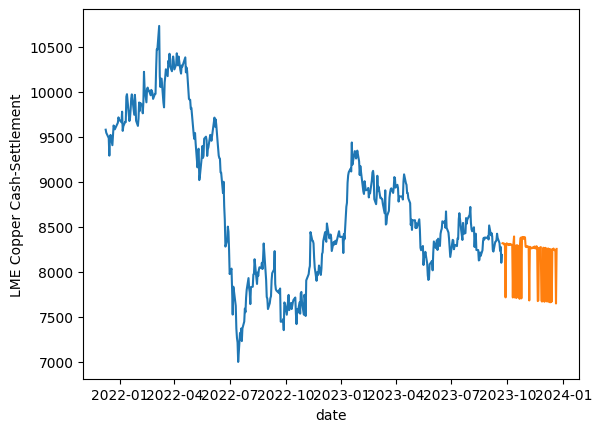

In [163]:
sns.lineplot(data.iloc[5000:,0])
sns.lineplot(prognosis_product_day)

### Line plot

---
---

### Доверительный интервал

Для формирования доверительного интервала для уже существующего временного ряда в Python вы можете использовать модуль `statsmodels` или функции из библиотеки `numpy`. Вот примеры кода:

Используя `statsmodels`:
```python
import pandas as pd
import statsmodels.api as sm

# Загрузка и предобработка временного ряда
data = pd.read_csv('YourDataset.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Построение модели временных рядов
model = sm.tsa.ARIMA(data, order=(2, 1, 2))
model_fit = model.fit()

# Прогноз на 90 дней вперед
forecast = model_fit.get_forecast(steps=90)

# Извлечение доверительных интервалов
confidence_intervals = forecast.conf_int(alpha=0.05)

# Вывод полученных результатов
print("Доверительные интервалы:")
print(confidence_intervals)
```

Используя `numpy`:
```python
import pandas as pd
import numpy as np

# Загрузка и предобработка временного ряда
data = pd.read_csv('YourDataset.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Вычисление среднего и стандартного отклонения
mean = data['Price'].mean()
std = data['Price'].std()

# Вычисление доверительного интервала с уровнем доверия 95%
n = data.shape[0]
confidence_interval = (mean - 1.96 * (std / np.sqrt(n)), mean + 1.96 * (std / np.sqrt(n)))

# Вывод полученных результатов
print("Доверительный интервал:")
print(confidence_interval)
```

В обоих примерах мы предполагаем, что у вас есть файл данных `YourDataset.csv`, содержащий столбец "Date" для даты и столбец "Price" для цен. Загружаем и предобрабатываем данные, затем строим модель временного ряда с помощью `sm.tsa.ARIMA()` или вычисляем среднее и стандартное отклонение с помощью `numpy`. Далее, используя соответствующие методы, мы получаем прогноз (если используется `statsmodels`) или вычисляем доверительный интервал. Наконец, выводим полученные результаты на экран.

Убедитесь, что вы устанавливаете необходимые зависимости, такие как `pandas`, `statsmodels` и `numpy`, с помощью команды `pip install pandas statsmodels numpy`.

Значение 1.96 используется для расчета доверительного интервала на основе нормального распределения с уровнем доверия 95%. 

В статистике и теории вероятностей, распределение Стьюдента (t-распределение) используется для расчета доверительных интервалов на основе небольших выборок. Однако, при достаточно большом размере выборки (обычно более 30 наблюдений), t-распределение асимптотически приближается к нормальному распределению. 

Для нормального распределения с уровнем доверия 95%, значение 1.96 соответствует двум стандартным отклонениям от среднего значения в каждую сторону (1.96 * стандартное отклонение). Использование этого значения позволяет получить доверительный интервал, который содержит примерно 95% значений из выборки приближенно к нормальному распределению.

Однако, если вы работаете с большими выборками или хотите использовать другой уровень доверия, то можно использовать другие значения квантилей для расчета доверительного интервала.

---
---

### Марковские цепи

Для расчета состояний для всех имеющихся наблюдений временного ряда вы можете использовать статистический метод, например, метод k-средних (k-means) или метод определения пороговых значений.

Вот пример использования метода k-средних для расчета состояний для всех имеющихся наблюдений временного ряда на Python:

```python
import pandas as pd
from sklearn.cluster import KMeans

# Здесь data - это ваш временной ряд

# Определение числа состояний
num_states = 3

# Создание модели k-средних
kmeans = KMeans(n_clusters=num_states, random_state=42)

# Преобразование данных в одномерный массив
X = data.values.reshape(-1, 1)

# Выполнение кластеризации
kmeans.fit(X)

# Получение меток состояний для каждого наблюдения
states = kmeans.labels_

# Создание столбца состояний в DataFrame с данными
data['states'] = states

# Вывод результатов
print(data)
```

В этом примере мы используем библиотеку `sklearn` для выполнения метода k-средних. Мы задаем количество состояний `num_states`, создаем объект модели `kmeans` и применяем его к одномерному массиву данных `X`. Затем мы получаем метки состояний для каждого наблюдения с помощью метода `labels_` и добавляем столбец состояний в исходный DataFrame с данными.

Вы можете настроить количество состояний `num_states` в соответствии с вашими требованиями и особенностями временного ряда. Также вы можете использовать другие методы для расчета состояний, в зависимости от ваших данных и конкретной задачи прогнозирования.

---

Для прогнозирования временного ряда на 90 дней вперед с использованием модели марковской цепи на Python вы можете использовать следующий код:

```python
import numpy as np
import pandas as pd
import pymc3 as pm

# Здесь data - это ваш временной ряд с уже определенными состояниями

# Определение состояний
states = data['states'].values

# Определение матрицы переходных вероятностей
transition_matrix = np.array([[0.7, 0.2, 0.1], [0.3, 0.6, 0.1], [0.1, 0.3, 0.6]])

# Определение начального распределения состояний
initial_state = np.array([0.3, 0.4, 0.3])

# Генерация прогноза состояний на 90 дней вперед
forecast_states = pm.sample_markov_chain(
    transition_matrix, initial_state, n_steps=90, random_seed=42
)

# Создание DataFrame с прогнозируемыми состояниями
forecast_df = pd.DataFrame({'forecast_state': forecast_states})

# Создание DataFrame со значениями временного ряда для прогноза
forecast_data = pd.DataFrame({'forecast_value': [np.nan] * 90})

# Объединение DataFrame прогнозных состояний и значений
forecast_result = pd.concat([forecast_df, forecast_data], axis=1)

# Вывод прогноза
print(forecast_result)
```

В этом примере мы предполагаем, что у нас уже есть определенные состояния `states` для всех имеющихся наблюдений временного ряда. Затем мы определяем матрицу переходных вероятностей `transition_matrix` и начальное распределение состояний `initial_state`.

С помощью функции `sample_markov_chain` из библиотеки `pymc3` мы генерируем прогноз состояний на 90 дней вперед. Затем мы создаем DataFrame с прогнозируемыми состояниями и DataFrame с прогнозируемыми значениями временного ряда (в данном примере используется NaN для этих значений). Затем мы объединяем эти DataFrame для получения окончательного прогноза в формате DataFrame.

Вы можете настроить матрицу переходных вероятностей `transition_matrix` и начальное распределение состояний `initial_state` в соответствии с вашими конкретными данными и требованиями.